# Attempt warm start pre-training of CU prediction tasks

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

import time


import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec
import viz as v

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## Load 5G classification data

In [7]:
check_df = pd.read_csv(f'data/highCu_cls_splits/cv0_train.tsv',sep='\t')
seq_len = len(check_df['upstream_region'].values[0])
check_df.head()

og_index      locus_tag                                    upstream_region  \
0       668  EQU24_RS03640  CAATTGCTGAGTTACATGGATGTAATGAATGCAGAAAATACAGGAG...   
1       706  EQU24_RS03830  GATTTGCGTAAAGCTAAGCCGAGTGCCGCGAAAGGTGTTTATATGA...   
2       710  EQU24_RS03850  CTATCATGAGCAAAGAAGAAAACGACGCAACAAAGAAATAGAAGTT...   
3       756  EQU24_RS04080  ATCGAGCCACCGAACCCCCTTCCAGAAGTTGTCGAAGTTATTTCAT...   
4       789  EQU24_RS04255  AGGAAGCTGGAGCTTCCGGGGTGTCTTTCCCAAGCTGGAGCTTGGG...   

       uMax  lowO2_fast_growth    lowCH4      MeOH  NoCu     medCu    highCu  \
0  1.243148           1.052587  0.832082 -1.547966   0.0  1.280822  1.084277   
1  1.042152           0.982020  0.041436 -1.268396   0.0  1.172465  0.788694   
2  0.288425          -0.005089 -0.685868 -2.000937   0.0  0.660665  0.754083   
3  0.696524           0.167099  0.017540 -0.952773   0.0  0.504812  0.636391   
4  0.426234           0.064453 -0.294702 -1.166528   0.0  0.976434  0.785287   

   ...    aa3_KO  crotonic_acid  CH4_500ppm  CH4_1000ppm  gene  \
0  ...  0.277148      -0.965229   -0.300738    -0.183536   NaN   
1  ... -0.554703       1.127968   -2.155047    -1.870994  rplJ   
2  ... -0.746728      -0.277687   -3.184635    -3.243279  rpsL   
3  ...  0.396319       0.977263    0.621202     0.693023   NaN   
4  ... -1.244025      -0.781154   -1.353288    -1.615418  rpmE   

                      product  type  highCu_reg_UD  \
0        hypothetical protein   CDS              2   
1   50S ribosomal protein L10   CDS              2   
2   30S ribosomal protein S12   CDS              2   
3  2-isopropylmalate synthase   CDS              2   
4   50S ribosomal protein L31   CDS              2   

                                        shuffled_seq    set  
0  TGAGTGATACTTGAACATTCCTTCTCAGCAGATTCTATATTAATAT...  train  
1  TTAATCAACTGCTGAATAAAGCTCAGGTAGAATGAATAGTGGATGC...  train  
2  CTAAACGGATTAAACTACGCGCTTGGATTAGGGGAAATGCCTTGAT...  train  
3  ATTCCATCTAATCACTTGCCTCTTATTTTCCTATCGTATTATCTAA...  train  
4  ACTTGTTGTAACCTGTCAGTACGGATGCCTCTCAATCTCTGAAATA...  train  

[5 rows x 26 columns]

# Warm start model from saved state dict

### load 5org classification model and confirm predictions on it's own data look correct


In [10]:
m_args_5org_cls = (seq_len,5)
m_kwargs = {
    "num_filters1":32,
    "num_filters2":32,
    "kernel_size1":10,
    "kernel_size2":6,
    "conv_pool_size1":2,
    "fc_node_num1":50,
    "fc_node_num2":50,
    "dropout1":0.25
}

saved_5org_cls_filename = 'saved_models/5org_cls_cv0_model_state_dict.pt'
model_5org_cls = m.DNA_2CNN_2FC(*m_args_5org_cls,**m_kwargs)
model_5org_cls.load_state_dict(torch.load(saved_5org_cls_filename))
model_5org_cls


DNA_2CNN_2FC(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=4480, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=5, bias=True)
  )
)

Running predictions for reloaded model_5org_cls


model_name  split  mac_precision  mac_recall    mac_f1  \
0  reloaded model_5org_cls  train       0.965631    0.965722  0.965618   
1  reloaded model_5org_cls   test       0.855052    0.851865  0.853281   

   support  
0    15399  
1     3850

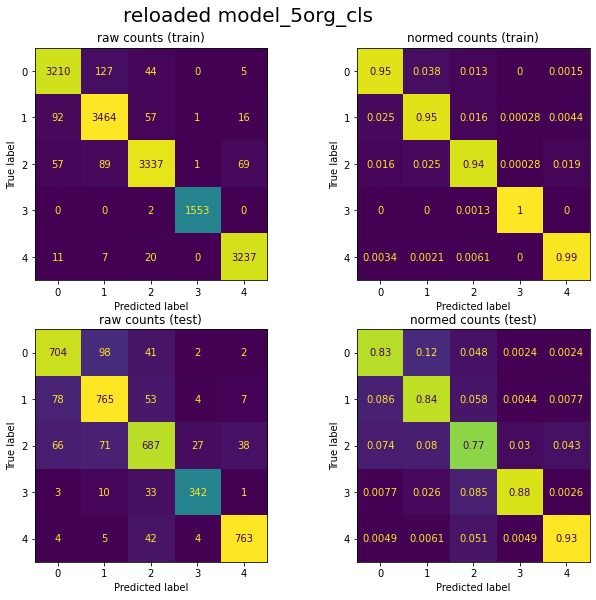

In [16]:
temp_train_df = pd.read_csv(f'data/5org_ups_cls_splits/cv0_train.tsv',sep='\t')
temp_test_df = pd.read_csv(f'data/5org_ups_cls_splits/cv0_test.tsv',sep='\t')

temp_seq_list = [
    (temp_train_df['upstream_region'].values,temp_train_df['id'],"train"),
    (temp_test_df['upstream_region'].values,temp_test_df['id'],"test")
]

tu.get_confusion_stats(
    model_5org_cls.to(DEVICE),
    'reloaded model_5org_cls',
    temp_seq_list,
    DEVICE,
    title=f"reloaded model_5org_cls",
)

looks good, now extract the relevant layers (all but the last layer)

In [18]:
def see_model_layers(model):
    extracted_layers = {k: v for k, v in model.state_dict().items()}
    extracted_layers_shapes = [(k,extracted_layers[k].shape) for k in extracted_layers]
    for x in extracted_layers_shapes:
        print(x)

In [19]:
see_model_layers(model_5org_cls)

('conv_net.0.weight', torch.Size([32, 1, 4, 10]))
('conv_net.0.bias', torch.Size([32]))
('conv_net.4.weight', torch.Size([32, 32, 1, 6]))
('conv_net.4.bias', torch.Size([32]))
('conv_net.8.weight', torch.Size([50, 4480]))
('conv_net.8.bias', torch.Size([50]))
('conv_net.10.weight', torch.Size([50, 50]))
('conv_net.10.bias', torch.Size([50]))
('conv_net.12.weight', torch.Size([5, 50]))
('conv_net.12.bias', torch.Size([5]))


Remove the weight and bias of the final layer, so we can change the prediction task head

In [21]:
# Exclude final layer of model.state_dict 
to_exclude = ['conv_net.12.weight', 'conv_net.12.bias']
model_5org_cls_weights = {k: v for k, v in model_5org_cls.state_dict().items() if k not in to_exclude}
model_5org_cls_weights.keys()

dict_keys(['conv_net.0.weight', 'conv_net.0.bias', 'conv_net.4.weight', 'conv_net.4.bias', 'conv_net.8.weight', 'conv_net.8.bias', 'conv_net.10.weight', 'conv_net.10.bias'])

### now try prediction task with warm models

In [22]:
model_res = {}
pred_dfs = {}

___Running CV0___


E:205 | train loss:0.032 | val loss: 0.848:   4%|▍         | 205/5000 [00:15<06:05, 13.13it/s]

EarlyStopping counter: 125 out of 500


E:330 | train loss:0.013 | val loss: 1.007:   7%|▋         | 331/5000 [00:25<05:53, 13.19it/s]

EarlyStopping counter: 250 out of 500


E:455 | train loss:0.006 | val loss: 1.137:   9%|▉         | 455/5000 [00:34<05:45, 13.14it/s]

EarlyStopping counter: 375 out of 500


E:578 | train loss:0.005 | val loss: 1.239:  12%|█▏        | 578/5000 [00:44<05:37, 13.09it/s]


EarlyStopping counter: 500 out of 500
Early stopping


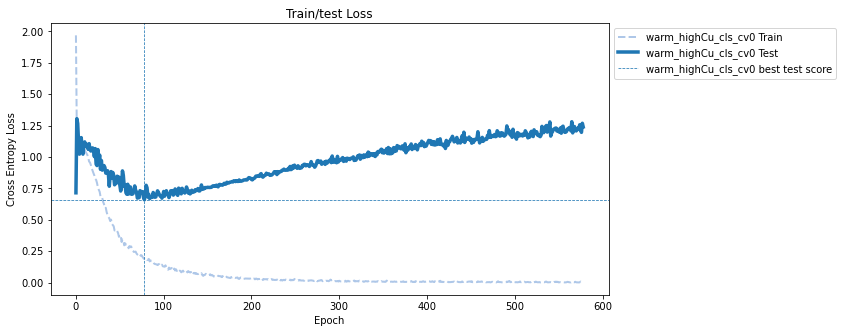

Running predictions for warm_highCu_cls_cv0
___Running CV1___


E:182 | train loss:0.034 | val loss: 0.885:   4%|▎         | 182/5000 [00:13<06:03, 13.24it/s]

EarlyStopping counter: 125 out of 500


E:307 | train loss:0.011 | val loss: 1.078:   6%|▌         | 308/5000 [00:23<05:54, 13.25it/s]

EarlyStopping counter: 250 out of 500


E:432 | train loss:0.009 | val loss: 1.212:   9%|▊         | 432/5000 [00:32<05:45, 13.23it/s]

EarlyStopping counter: 375 out of 500


E:555 | train loss:0.002 | val loss: 1.347:  11%|█         | 555/5000 [00:42<05:36, 13.21it/s]


EarlyStopping counter: 500 out of 500
Early stopping


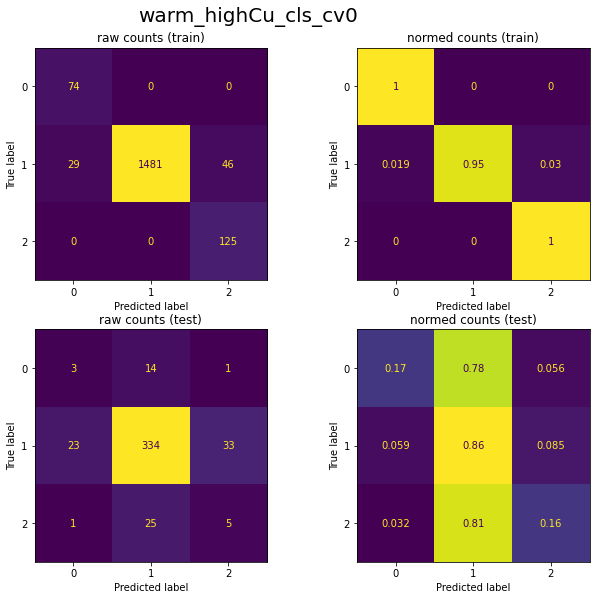

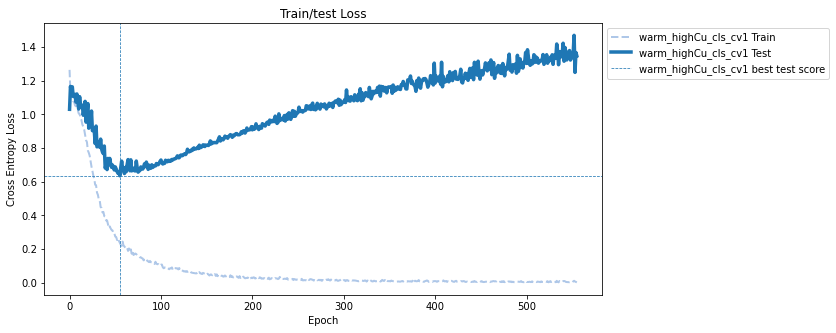

Running predictions for warm_highCu_cls_cv1
___Running CV2___


E:181 | train loss:0.035 | val loss: 0.978:   4%|▎         | 181/5000 [00:13<06:03, 13.25it/s]

EarlyStopping counter: 125 out of 500


E:306 | train loss:0.017 | val loss: 1.170:   6%|▌         | 307/5000 [00:23<05:55, 13.19it/s]

EarlyStopping counter: 250 out of 500


E:431 | train loss:0.005 | val loss: 1.286:   9%|▊         | 431/5000 [00:32<05:45, 13.22it/s]

EarlyStopping counter: 375 out of 500


E:554 | train loss:0.003 | val loss: 1.391:  11%|█         | 554/5000 [00:42<05:38, 13.14it/s]


EarlyStopping counter: 500 out of 500
Early stopping


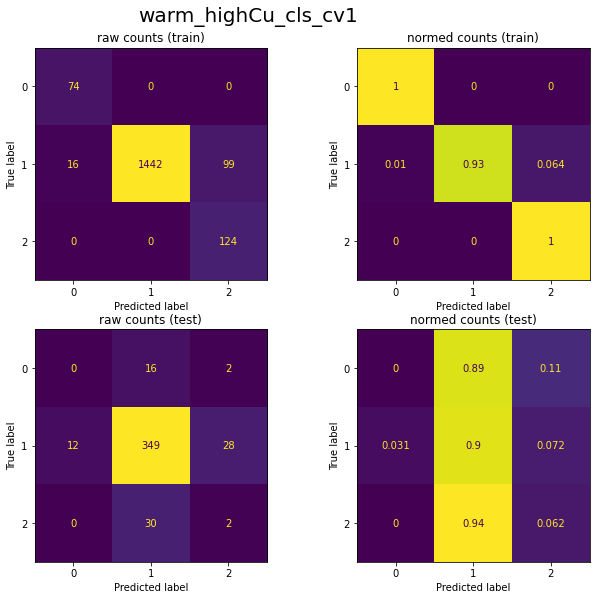

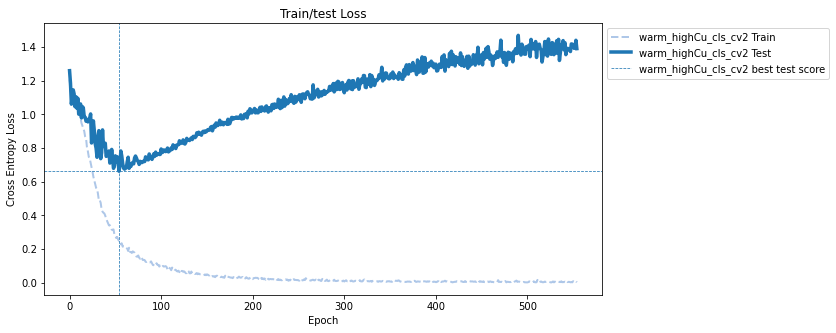

Running predictions for warm_highCu_cls_cv2
___Running CV3___


E:197 | train loss:0.028 | val loss: 0.903:   4%|▍         | 198/5000 [00:15<06:05, 13.12it/s]

EarlyStopping counter: 125 out of 500


E:322 | train loss:0.009 | val loss: 1.066:   6%|▋         | 322/5000 [00:24<05:54, 13.21it/s]

EarlyStopping counter: 250 out of 500


E:447 | train loss:0.004 | val loss: 1.193:   9%|▉         | 448/5000 [00:34<05:43, 13.24it/s]

EarlyStopping counter: 375 out of 500


E:570 | train loss:0.003 | val loss: 1.247:  11%|█▏        | 570/5000 [00:43<05:37, 13.13it/s]


EarlyStopping counter: 500 out of 500
Early stopping


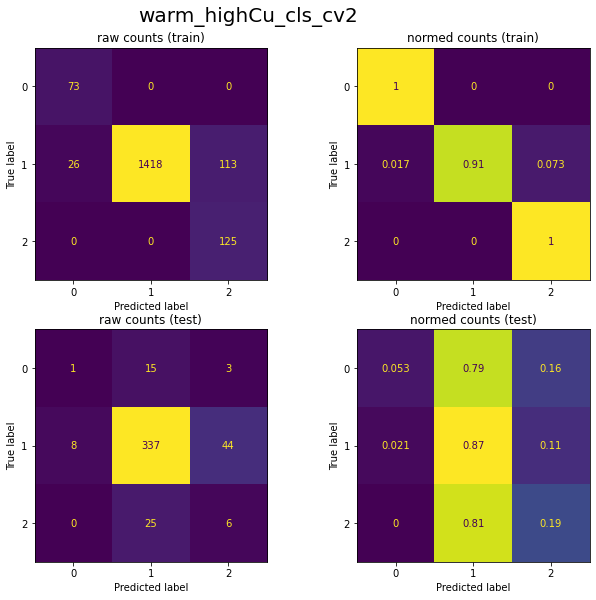

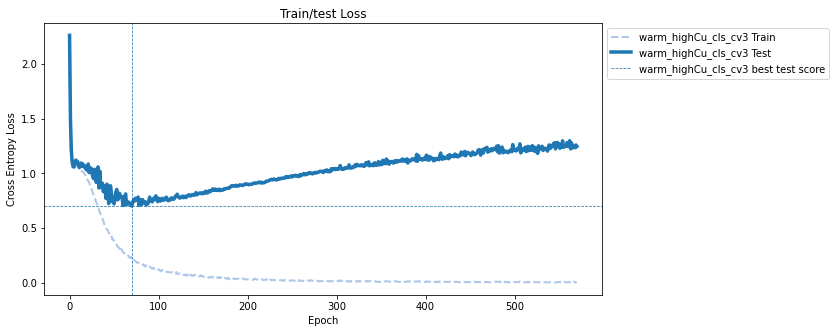

Running predictions for warm_highCu_cls_cv3
___Running CV4___


E:180 | train loss:0.024 | val loss: 0.812:   4%|▎         | 180/5000 [00:14<06:10, 13.00it/s]

EarlyStopping counter: 125 out of 500


E:305 | train loss:0.010 | val loss: 1.013:   6%|▌         | 306/5000 [00:23<06:00, 13.01it/s]

EarlyStopping counter: 250 out of 500


E:430 | train loss:0.003 | val loss: 1.113:   9%|▊         | 430/5000 [00:33<05:49, 13.08it/s]

EarlyStopping counter: 375 out of 500


E:553 | train loss:0.002 | val loss: 1.173:  11%|█         | 553/5000 [00:42<05:42, 12.98it/s]


EarlyStopping counter: 500 out of 500
Early stopping


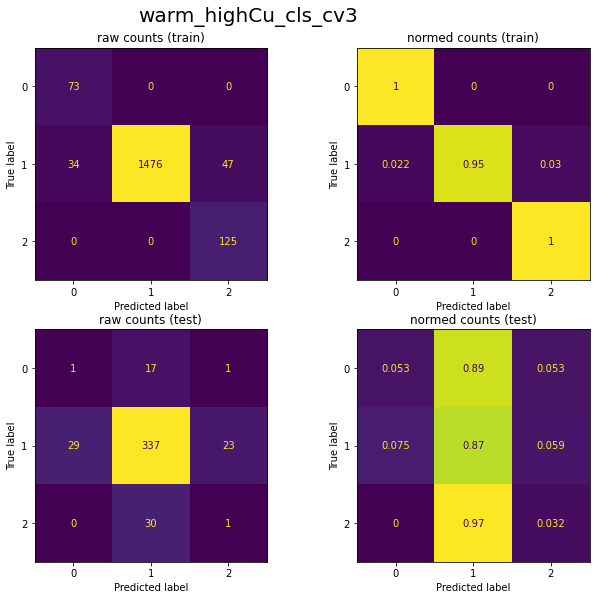

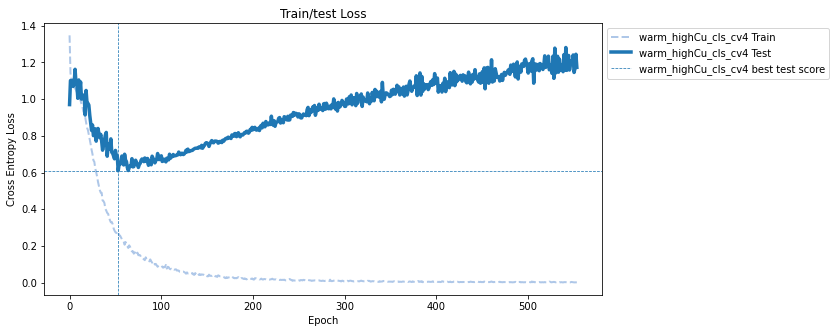

Running predictions for warm_highCu_cls_cv4


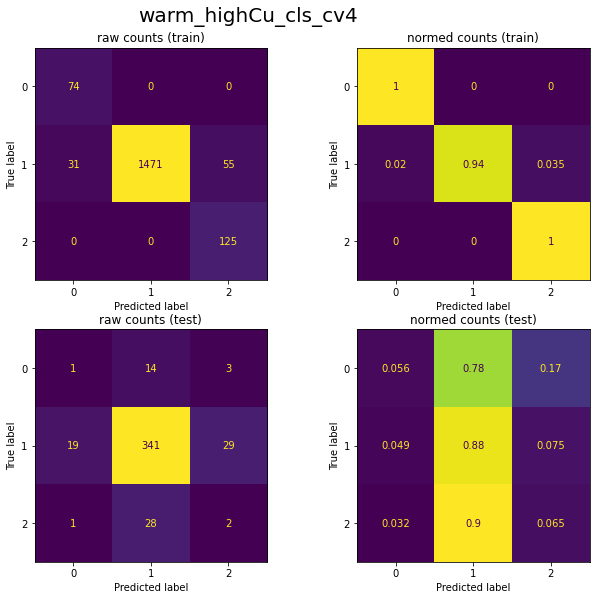

In [23]:
presplit_dir = 'highCu_cls_splits'
target_col = 'highCu_reg_UD'
seq_col = 'upstream_region'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    seq_list = [
        (train_df[seq_col].values,train_df[target_col],"train"),
        (test_df[seq_col].values,test_df[target_col],"test")
    ]

    # create data loaders
    sampler = tu.make_weighted_sampler(train_df,target_col)
    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    sampler=sampler,
                    shuffle=False,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_cls = (seq_len,3)
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_cls,**m_kwargs)
    model.load_state_dict(model_5org_cls_weights,strict=False)
    model_name = f"warm_highCu_cls_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='classification'
    )

    model_res[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.get_confusion_stats(
        t_res['model'],
        t_res['model_name'],
        seq_list,
        DEVICE,
        title=f"{t_res['model_name']}",
        #save_file=f"{out_dir}/{model_name}_confmat.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "regular"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_cls'
    p_res_df['start'] = 'model_5org_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs[model_name] = p_res_df

### train warm starts for shuffled seqs

___Running CV0___


E:197 | train loss:0.023 | val loss: 0.832:   4%|▍         | 197/5000 [00:15<06:05, 13.13it/s]

EarlyStopping counter: 125 out of 500


E:322 | train loss:0.008 | val loss: 1.009:   6%|▋         | 323/5000 [00:24<05:55, 13.15it/s]

EarlyStopping counter: 250 out of 500


E:447 | train loss:0.003 | val loss: 1.125:   9%|▉         | 447/5000 [00:34<05:45, 13.17it/s]

EarlyStopping counter: 375 out of 500


E:570 | train loss:0.003 | val loss: 1.267:  11%|█▏        | 570/5000 [00:43<05:38, 13.09it/s]


EarlyStopping counter: 500 out of 500
Early stopping


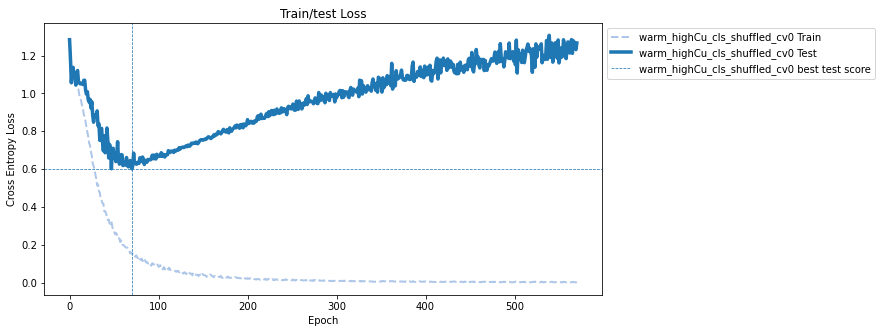

Running predictions for warm_highCu_cls_shuffled_cv0
___Running CV1___


E:181 | train loss:0.030 | val loss: 0.873:   4%|▎         | 182/5000 [00:13<06:02, 13.29it/s]

EarlyStopping counter: 125 out of 500


E:306 | train loss:0.009 | val loss: 1.040:   6%|▌         | 306/5000 [00:23<05:55, 13.21it/s]

EarlyStopping counter: 250 out of 500


E:431 | train loss:0.003 | val loss: 1.179:   9%|▊         | 432/5000 [00:32<05:45, 13.23it/s]

EarlyStopping counter: 375 out of 500


E:554 | train loss:0.003 | val loss: 1.349:  11%|█         | 554/5000 [00:41<05:37, 13.19it/s]


EarlyStopping counter: 500 out of 500
Early stopping


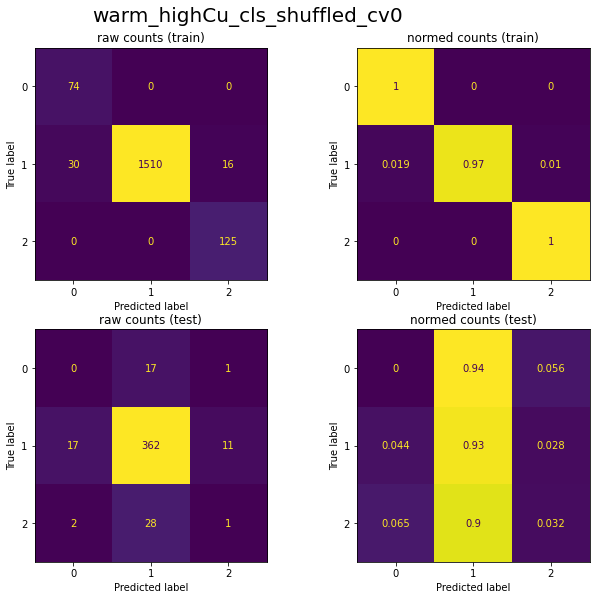

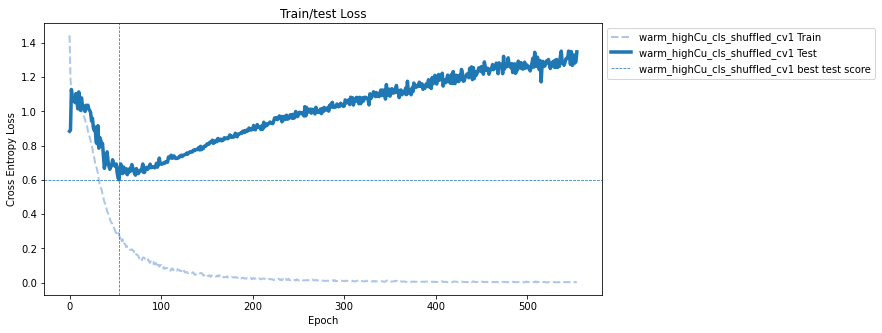

Running predictions for warm_highCu_cls_shuffled_cv1
___Running CV2___


E:171 | train loss:0.032 | val loss: 0.910:   3%|▎         | 171/5000 [00:13<06:06, 13.17it/s]

EarlyStopping counter: 125 out of 500


E:296 | train loss:0.012 | val loss: 1.115:   6%|▌         | 297/5000 [00:22<05:56, 13.18it/s]

EarlyStopping counter: 250 out of 500


E:421 | train loss:0.003 | val loss: 1.211:   8%|▊         | 421/5000 [00:32<05:46, 13.20it/s]

EarlyStopping counter: 375 out of 500


E:544 | train loss:0.002 | val loss: 1.346:  11%|█         | 544/5000 [00:41<05:39, 13.11it/s]


EarlyStopping counter: 500 out of 500
Early stopping


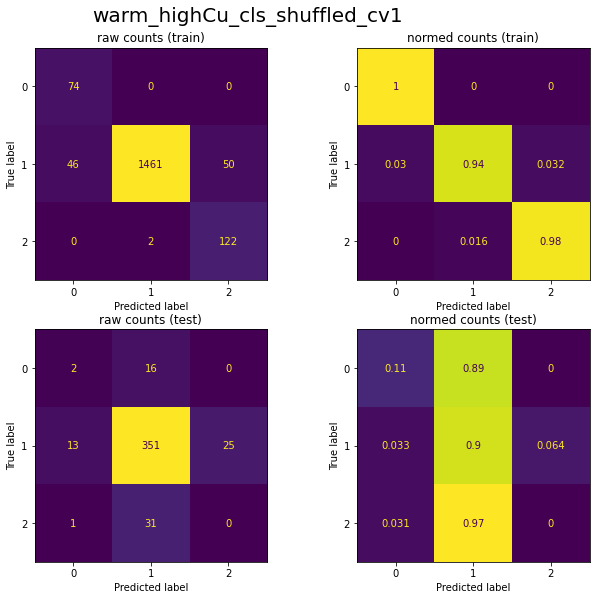

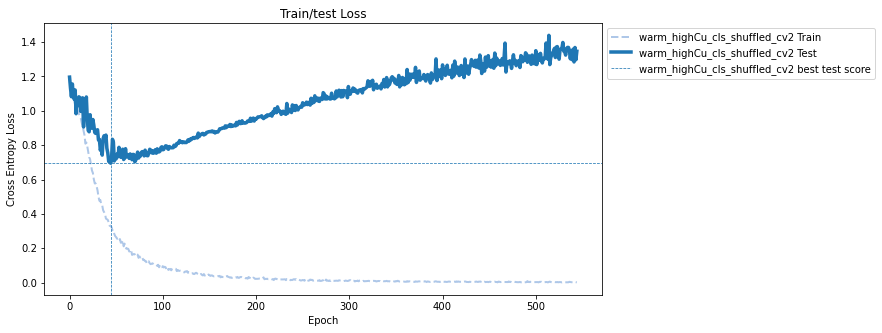

Running predictions for warm_highCu_cls_shuffled_cv2
___Running CV3___


E:208 | train loss:0.023 | val loss: 0.768:   4%|▍         | 208/5000 [00:15<06:03, 13.19it/s]

EarlyStopping counter: 125 out of 500


E:333 | train loss:0.010 | val loss: 0.919:   7%|▋         | 334/5000 [00:25<05:53, 13.20it/s]

EarlyStopping counter: 250 out of 500


E:458 | train loss:0.011 | val loss: 1.017:   9%|▉         | 458/5000 [00:34<05:45, 13.15it/s]

EarlyStopping counter: 375 out of 500


E:581 | train loss:0.005 | val loss: 1.166:  12%|█▏        | 581/5000 [00:44<05:36, 13.13it/s]


EarlyStopping counter: 500 out of 500
Early stopping


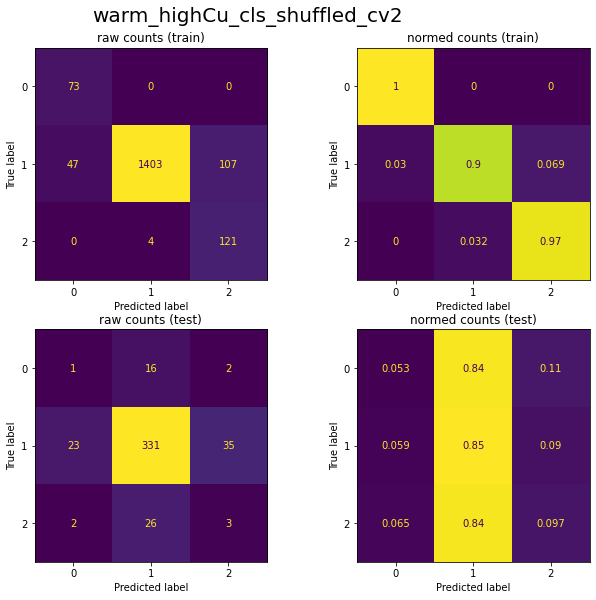

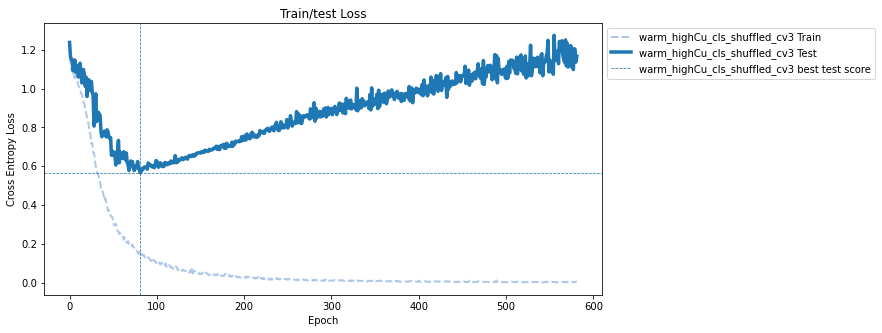

Running predictions for warm_highCu_cls_shuffled_cv3
___Running CV4___


E:196 | train loss:0.023 | val loss: 1.003:   4%|▍         | 196/5000 [00:15<06:07, 13.06it/s]

EarlyStopping counter: 125 out of 500


E:321 | train loss:0.007 | val loss: 1.202:   6%|▋         | 322/5000 [00:24<05:57, 13.07it/s]

EarlyStopping counter: 250 out of 500


E:446 | train loss:0.004 | val loss: 1.374:   9%|▉         | 446/5000 [00:34<05:48, 13.06it/s]

EarlyStopping counter: 375 out of 500


E:569 | train loss:0.002 | val loss: 1.530:  11%|█▏        | 569/5000 [00:43<05:41, 12.99it/s]


EarlyStopping counter: 500 out of 500
Early stopping


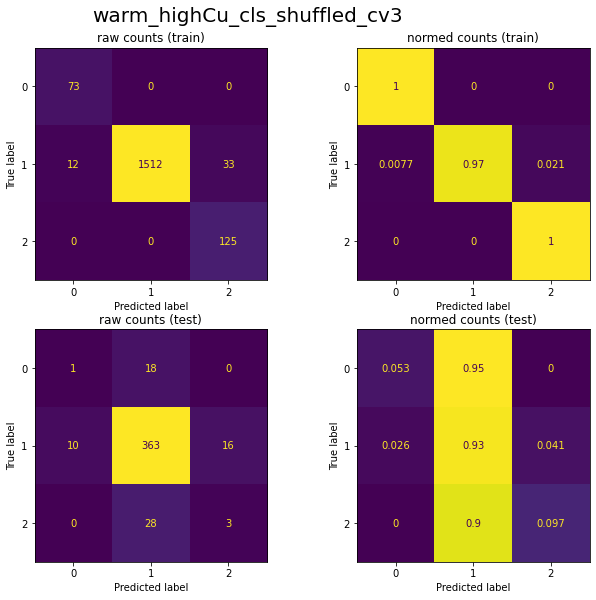

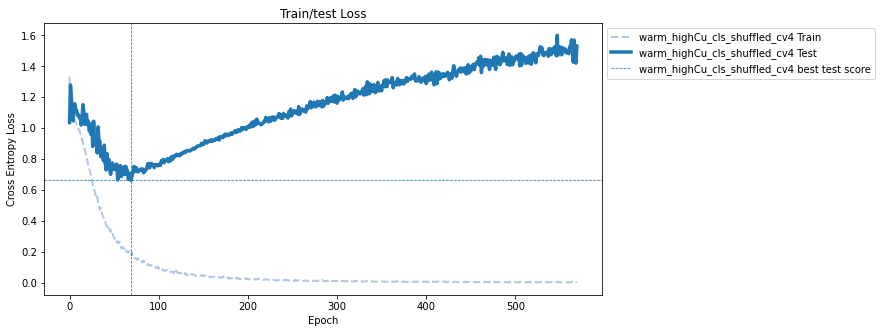

Running predictions for warm_highCu_cls_shuffled_cv4


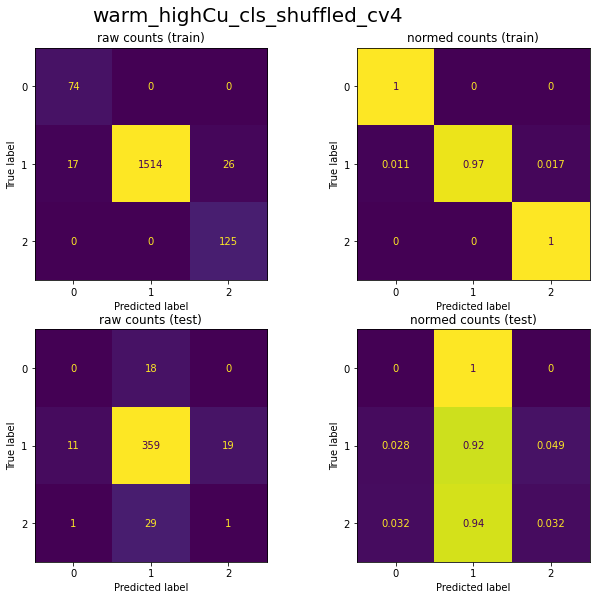

In [25]:
presplit_dir = 'highCu_cls_splits'
target_col = 'highCu_reg_UD'
seq_col = 'shuffled_seq'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    seq_list = [
        (train_df[seq_col].values,train_df[target_col],"train"),
        (test_df[seq_col].values,test_df[target_col],"test")
    ]

    # create data loaders
    sampler = tu.make_weighted_sampler(train_df,target_col)
    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    sampler=sampler,
                    shuffle=False,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_cls = (seq_len,3)
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_cls,**m_kwargs)
    model.load_state_dict(model_5org_cls_weights,strict=False)
    model_name = f"warm_highCu_cls_shuffled_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='classification'
    )

    model_res[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.get_confusion_stats(
        t_res['model'],
        t_res['model_name'],
        seq_list,
        DEVICE,
        title=f"{t_res['model_name']}",
        #save_file=f"{out_dir}/{model_name}_confmat.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "shuffled"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_cls'
    p_res_df['start'] = 'model_5org_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs[model_name] = p_res_df

In [26]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

model_name  split  mac_precision  mac_recall    mac_f1  \
0           warm_highCu_cls_cv0  train       0.816480    0.983933  0.885352   
1           warm_highCu_cls_cv0   test       0.378253    0.394789  0.383894   
0           warm_highCu_cls_cv1  train       0.792759    0.975380  0.859597   
1           warm_highCu_cls_cv1   test       0.315348    0.319891  0.317602   
0           warm_highCu_cls_cv2  train       0.754195    0.970242  0.830273   
1           warm_highCu_cls_cv2   test       0.372739    0.370835  0.364727   
0           warm_highCu_cls_cv3  train       0.802996    0.982659  0.875385   
1           warm_highCu_cls_cv3   test       0.316979    0.317071  0.316153   
0           warm_highCu_cls_cv4  train       0.799735    0.981589  0.872695   
1           warm_highCu_cls_cv4   test       0.332261    0.332226  0.332080   
0  warm_highCu_cls_shuffled_cv0  train       0.866021    0.990146  0.918769   
1  warm_highCu_cls_shuffled_cv0   test       0.322119    0.320154  0.317954   
0  warm_highCu_cls_shuffled_cv1  train       0.774867    0.974071  0.851587   
1  warm_highCu_cls_shuffled_cv1   test       0.335637    0.337808  0.336547   
0  warm_highCu_cls_shuffled_cv2  train       0.712064    0.956364  0.796241   
1  warm_highCu_cls_shuffled_cv2   test       0.333620    0.333435  0.332573   
0  warm_highCu_cls_shuffled_cv3  train       0.883321    0.990366  0.930927   
1  warm_highCu_cls_shuffled_cv3   test       0.378778    0.360856  0.365480   
0  warm_highCu_cls_shuffled_cv4  train       0.880334    0.990794  0.929588   
1  warm_highCu_cls_shuffled_cv4   test       0.311412    0.318379  0.314120   

   support model_type  seq_mode  fold        task                   start  \
0     1755        CNN   regular     0  highCu_cls  model_5org_cls_weights   
1      439        CNN   regular     0  highCu_cls  model_5org_cls_weights   
0     1755        CNN   regular     1  highCu_cls  model_5org_cls_weights   
1      439        CNN   regular     1  highCu_cls  model_5org_cls_weights   
0     1755        CNN   regular     2  highCu_cls  model_5org_cls_weights   
1      439        CNN   regular     2  highCu_cls  model_5org_cls_weights   
0     1755        CNN   regular     3  highCu_cls  model_5org_cls_weights   
1      439        CNN   regular     3  highCu_cls  model_5org_cls_weights   
0     1756        CNN   regular     4  highCu_cls  model_5org_cls_weights   
1      438        CNN   regular     4  highCu_cls  model_5org_cls_weights   
0     1755        CNN  shuffled     0  highCu_cls  model_5org_cls_weights   
1      439        CNN  shuffled     0  highCu_cls  model_5org_cls_weights   
0     1755        CNN  shuffled     1  highCu_cls  model_5org_cls_weights   
1      439        CNN  shuffled     1  highCu_cls  model_5org_cls_weights   
0     1755        CNN  shuffled     2  highCu_cls  model_5org_cls_weights   
1      439        CNN  shuffled     2  highCu_cls  model_5org_cls_weights   
0     1755        CNN  shuffled     3  highCu_cls  model_5org_cls_weights   
1      439        CNN  shuffled     3  highCu_cls  model_5org_cls_weights   
0     1756        CNN  shuffled     4  highCu_cls  model_5org_cls_weights   
1      438        CNN  shuffled     4  highCu_cls  model_5org_cls_weights   

   best_val_score  epoch_stop  total_time  
0        0.659545          78   44.152330  
1        0.659545          78   44.152330  
0        0.635083          55   42.024172  
1        0.635083          55   42.024172  
0        0.662632          54   42.162211  
1        0.662632          54   42.162211  
0        0.701060          70   43.431417  
1        0.701060          70   43.431417  
0        0.609581          53   42.591905  
1        0.609581          53   42.591905  
0        0.601528          70   43.558363  
1        0.601528          70   43.558363  
0        0.600656          54   42.000310  
1        0.600656          54   42.000310  
0        0.694908          44   41.490571  
1        0.694908          44   41.4905

In [27]:
def plot_metric(df,metric):
    sns.barplot(data=df,y='model_name',x=metric,hue='split',dodge=True)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.xlabel(f"{metric} score",fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("")
    plt.yticks(fontsize=14)
    plt.show()

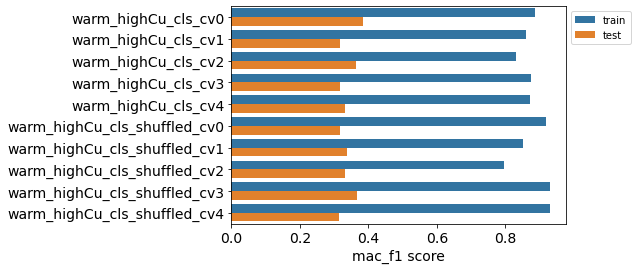

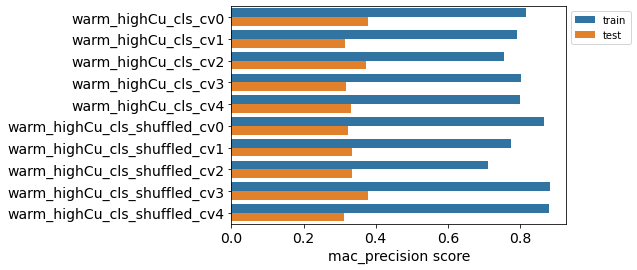

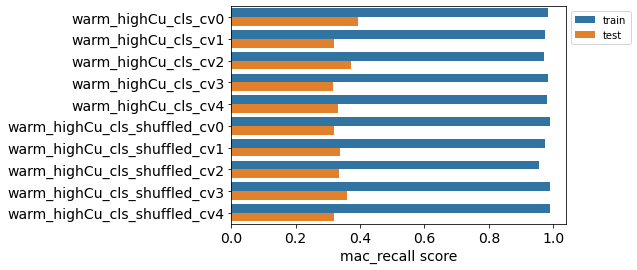

In [28]:
plot_metric(all_preds,'mac_f1')
plot_metric(all_preds,'mac_precision')
plot_metric(all_preds,'mac_recall')

In [29]:
df_train = all_preds[all_preds['split']=='train']
df_test = all_preds[all_preds['split']=='test']

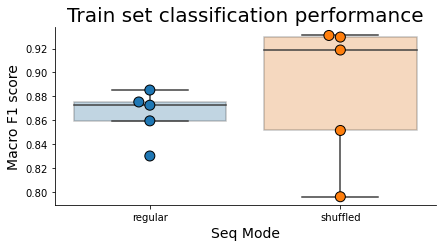

In [30]:
g = sns.catplot(
    data=df_train, x='seq_mode', y='mac_f1',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='mac_f1',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Train set classification performance",fontsize=20)
plt.show()

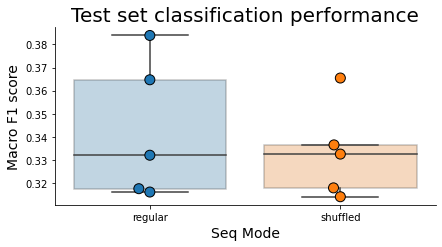

In [31]:
g = sns.catplot(
    data=df_test, x='seq_mode', y='mac_f1',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='mac_f1',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set classification performance",fontsize=20)
plt.show()

In [32]:
from scipy.stats import ttest_ind

In [33]:
regular_scores = df_test[df_test['seq_mode']=='regular']['mac_f1'].values
shuffled_scores = df_test[df_test['seq_mode']=='shuffled']['mac_f1'].values
print("T-test:",ttest_ind(regular_scores, shuffled_scores))
print()
print("Mean Mac F1 for regular seqs:",np.mean(regular_scores))
print("Mean Mac F1 for shuffled seqs:",np.mean(shuffled_scores))

T-test: Ttest_indResult(statistic=0.5881851320215944, pvalue=0.5726341984226273)

Mean Mac F1 for regular seqs: 0.3428911816296078
Mean Mac F1 for shuffled seqs: 0.33333482534463976


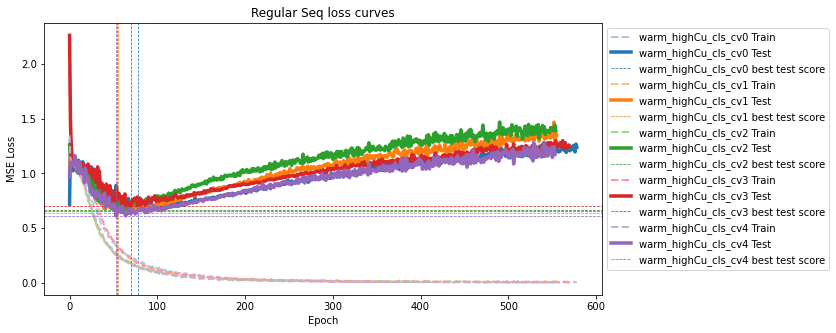

<Figure size 432x288 with 0 Axes>

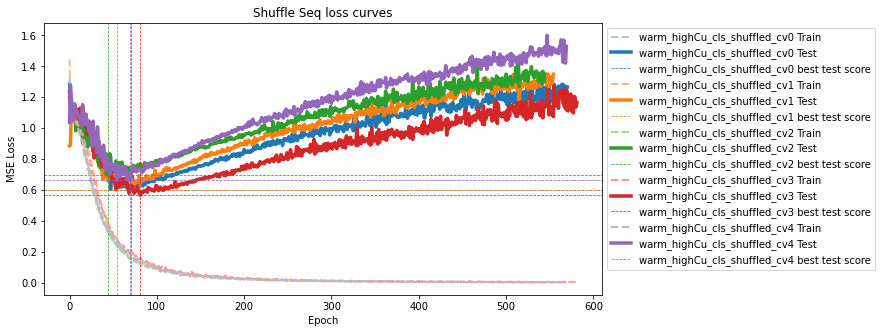

<Figure size 432x288 with 0 Axes>

In [49]:
tu.quick_loss_plot(
    [model_res[x]['data_label'][0] for x in model_res if "shuffle" not in x],
    title="Regular Seq loss curves",
    loss_str = "MSE Loss",
    save_file = 'out_warmStart_highCu_cls/regular_seq_W:5orgCLS_loss_plot.png'
)

tu.quick_loss_plot(
    [model_res[x]['data_label'][0] for x in model_res if "shuffle" in x],
    title="Shuffle Seq loss curves",
    loss_str = "MSE Loss",
    save_file = 'out_warmStart_highCu_cls/shuffle_seq_W:5orgCLS_loss_plot.png'
)

CHECK RESULTS?^^?

In [ ]:
# hm, wait and try other warm starts too?
#all_preds.to_csv('out_warmStart_highCu_cls/all_pred_res.tsv',sep='\t',index=False)


## Try warm start on 5org_cls for *Regression* task

In [37]:
model_res_regr = {}
pred_dfs_regr = {}

___Running CV0___


E:177 | train loss:1.791 | val loss: 4.564:   4%|▎         | 177/5000 [00:13<06:13, 12.90it/s]

EarlyStopping counter: 125 out of 500


E:302 | train loss:0.936 | val loss: 4.742:   6%|▌         | 303/5000 [00:23<06:05, 12.86it/s]

EarlyStopping counter: 250 out of 500


E:427 | train loss:0.553 | val loss: 4.726:   9%|▊         | 427/5000 [00:33<05:55, 12.86it/s]

EarlyStopping counter: 375 out of 500


E:550 | train loss:0.440 | val loss: 4.619:  11%|█         | 550/5000 [00:42<05:46, 12.83it/s]


EarlyStopping counter: 500 out of 500
Early stopping


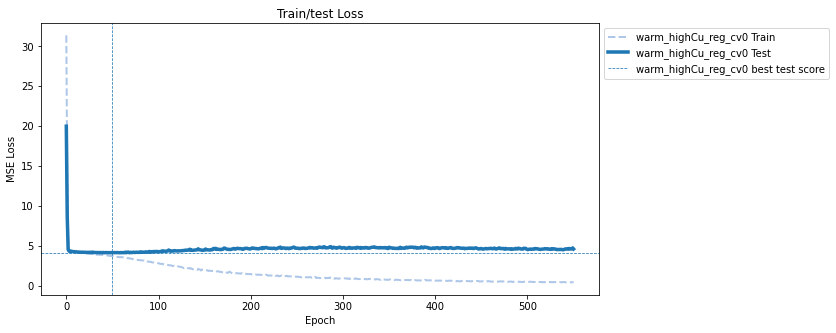

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_highCu_reg_cv0
test split
Predicting for warm_highCu_reg_cv0


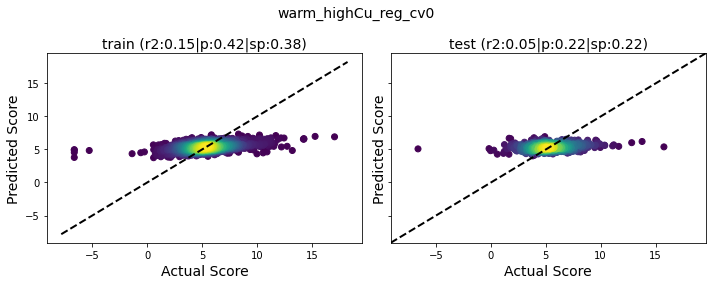

___Running CV1___


E:217 | train loss:1.297 | val loss: 4.683:   4%|▍         | 218/5000 [00:16<06:08, 12.98it/s]

EarlyStopping counter: 125 out of 500


E:342 | train loss:0.719 | val loss: 4.666:   7%|▋         | 342/5000 [00:26<05:59, 12.96it/s]

EarlyStopping counter: 250 out of 500


E:467 | train loss:0.496 | val loss: 4.620:   9%|▉         | 468/5000 [00:36<05:51, 12.91it/s]

EarlyStopping counter: 375 out of 500


E:590 | train loss:0.373 | val loss: 4.504:  12%|█▏        | 590/5000 [00:45<05:41, 12.90it/s]


EarlyStopping counter: 500 out of 500
Early stopping


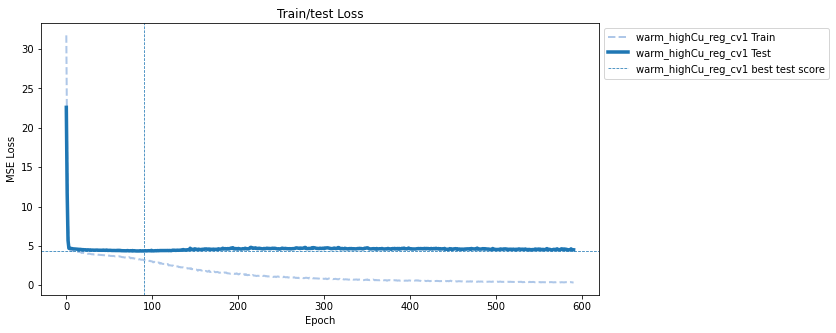

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_highCu_reg_cv1
test split
Predicting for warm_highCu_reg_cv1


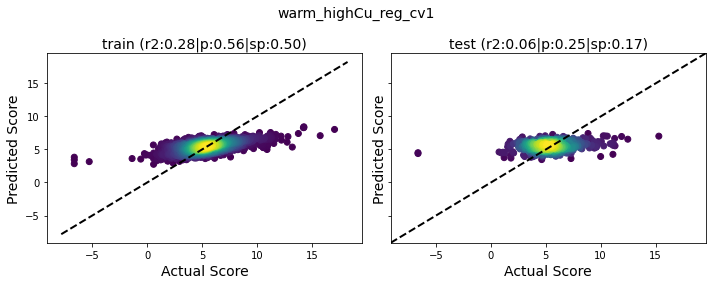

___Running CV2___


E:186 | train loss:1.453 | val loss: 3.808:   4%|▎         | 186/5000 [00:14<06:11, 12.97it/s]

EarlyStopping counter: 125 out of 500


E:311 | train loss:0.780 | val loss: 3.864:   6%|▌         | 312/5000 [00:24<06:01, 12.97it/s]

EarlyStopping counter: 250 out of 500


E:436 | train loss:0.510 | val loss: 3.846:   9%|▊         | 436/5000 [00:33<05:51, 12.99it/s]

EarlyStopping counter: 375 out of 500


E:559 | train loss:0.396 | val loss: 3.757:  11%|█         | 559/5000 [00:43<05:43, 12.93it/s]


EarlyStopping counter: 500 out of 500
Early stopping


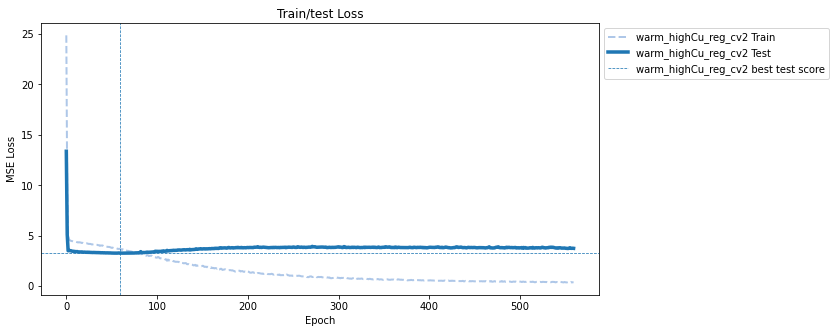

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_highCu_reg_cv2
test split
Predicting for warm_highCu_reg_cv2


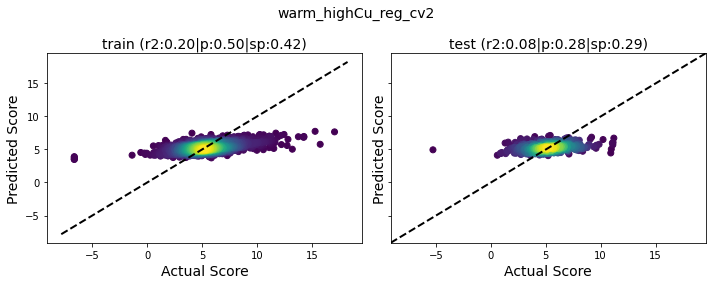

___Running CV3___


E:131 | train loss:2.499 | val loss: 4.614:   3%|▎         | 132/5000 [00:10<06:13, 13.05it/s]

EarlyStopping counter: 125 out of 500


E:256 | train loss:1.076 | val loss: 5.099:   5%|▌         | 256/5000 [00:19<06:04, 13.00it/s]

EarlyStopping counter: 250 out of 500


E:381 | train loss:0.689 | val loss: 5.061:   8%|▊         | 382/5000 [00:29<05:54, 13.02it/s]

EarlyStopping counter: 375 out of 500


E:504 | train loss:0.543 | val loss: 4.825:  10%|█         | 504/5000 [00:38<05:45, 13.00it/s]


EarlyStopping counter: 500 out of 500
Early stopping


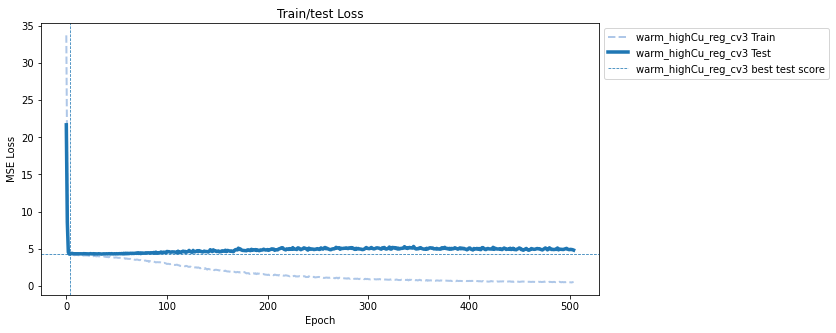

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_highCu_reg_cv3
test split
Predicting for warm_highCu_reg_cv3


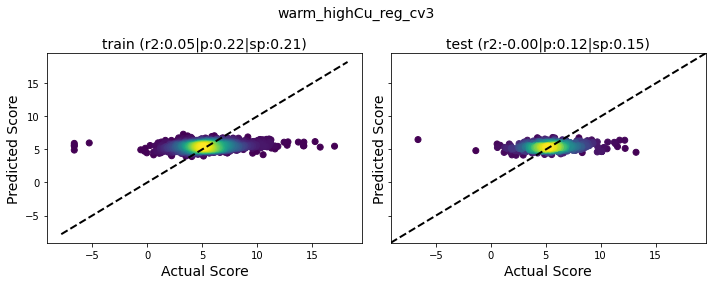

___Running CV4___


E:180 | train loss:1.451 | val loss: 5.138:   4%|▎         | 180/5000 [00:13<06:09, 13.05it/s]

EarlyStopping counter: 125 out of 500


E:305 | train loss:0.733 | val loss: 5.008:   6%|▌         | 306/5000 [00:23<06:00, 13.03it/s]

EarlyStopping counter: 250 out of 500


E:430 | train loss:0.482 | val loss: 4.971:   9%|▊         | 430/5000 [00:33<05:49, 13.06it/s]

EarlyStopping counter: 375 out of 500


E:553 | train loss:0.386 | val loss: 4.830:  11%|█         | 553/5000 [00:42<05:41, 13.02it/s]


EarlyStopping counter: 500 out of 500
Early stopping


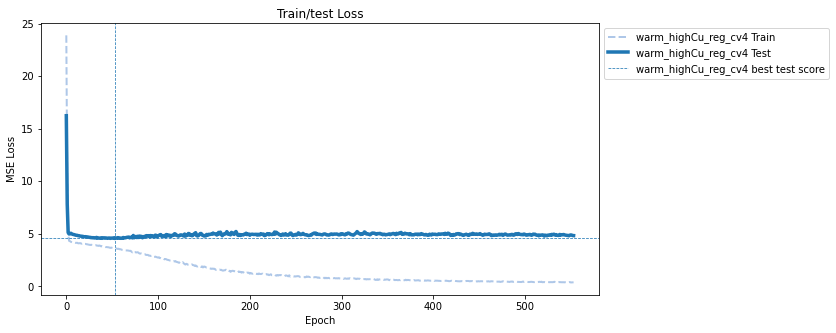

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_highCu_reg_cv4
test split
Predicting for warm_highCu_reg_cv4


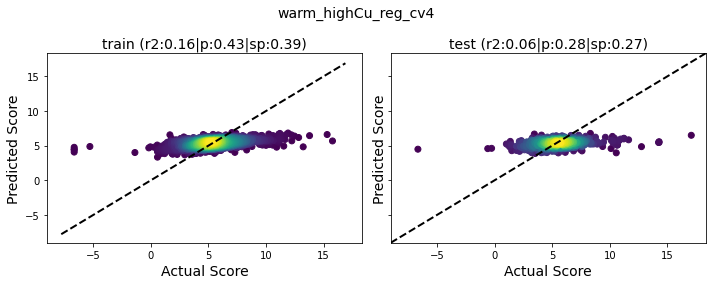

In [38]:
presplit_dir = 'highCu_logTPM_reg_splits'
target_col = 'highCu'
seq_col = 'upstream_region'
locus_col = 'locus_tag'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    split_dfs = {
        'train':train_df,
        'test':test_df
    }

    # create data loaders    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    # NO SAMPLER for regression
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_reg = (seq_len,1) # single task regression
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_reg,**m_kwargs)
    model.load_state_dict(model_5org_cls_weights,strict=False)
    model_name = f"warm_highCu_reg_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='regression'
    )

    model_res_regr[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.parity_pred_by_split(
        model,
        model_name,
        DEVICE,
        split_dfs,
        locus_col=locus_col,
        seq_col=seq_col,
        target_col=target_col,
        splits=['train','test'],
        #save_file=f"{out_dir}/{model_name}_parity_plot.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "regular"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_logTPM_regr'
    p_res_df['start'] = 'model_5org_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs_regr[model_name] = p_res_df

### Regression from 5org_cls shuffled

___Running CV0___


E:151 | train loss:2.098 | val loss: 5.361:   3%|▎         | 152/5000 [00:11<06:10, 13.08it/s]

EarlyStopping counter: 125 out of 500


E:276 | train loss:0.906 | val loss: 5.462:   6%|▌         | 276/5000 [00:21<06:01, 13.06it/s]

EarlyStopping counter: 250 out of 500


E:401 | train loss:0.558 | val loss: 5.451:   8%|▊         | 402/5000 [00:30<05:52, 13.04it/s]

EarlyStopping counter: 375 out of 500


E:524 | train loss:0.438 | val loss: 5.236:  10%|█         | 524/5000 [00:40<05:43, 13.03it/s]


EarlyStopping counter: 500 out of 500
Early stopping


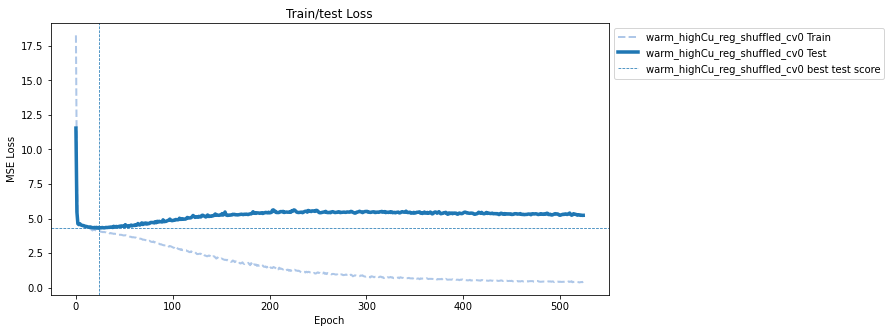

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_highCu_reg_shuffled_cv0
test split
Predicting for warm_highCu_reg_shuffled_cv0


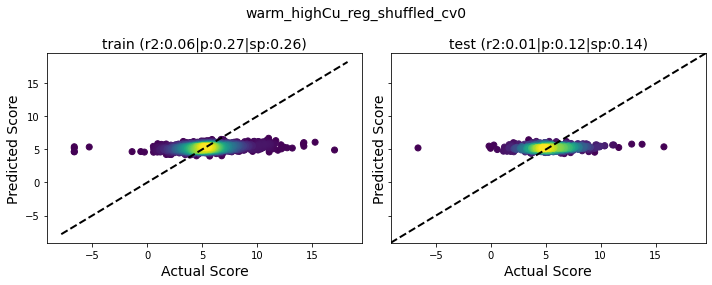

___Running CV1___


E:148 | train loss:2.058 | val loss: 5.304:   3%|▎         | 148/5000 [00:11<06:09, 13.13it/s]

EarlyStopping counter: 125 out of 500


E:273 | train loss:0.920 | val loss: 5.751:   5%|▌         | 274/5000 [00:20<06:00, 13.10it/s]

EarlyStopping counter: 250 out of 500


E:398 | train loss:0.528 | val loss: 5.534:   8%|▊         | 398/5000 [00:30<05:50, 13.14it/s]

EarlyStopping counter: 375 out of 500


E:521 | train loss:0.389 | val loss: 5.518:  10%|█         | 521/5000 [00:39<05:42, 13.07it/s]


EarlyStopping counter: 500 out of 500
Early stopping


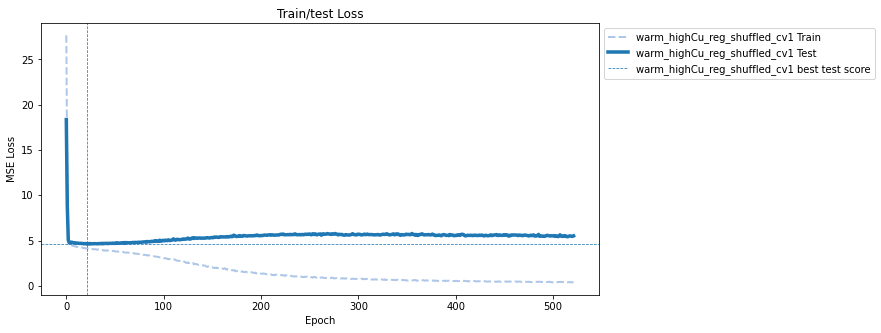

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_highCu_reg_shuffled_cv1
test split
Predicting for warm_highCu_reg_shuffled_cv1


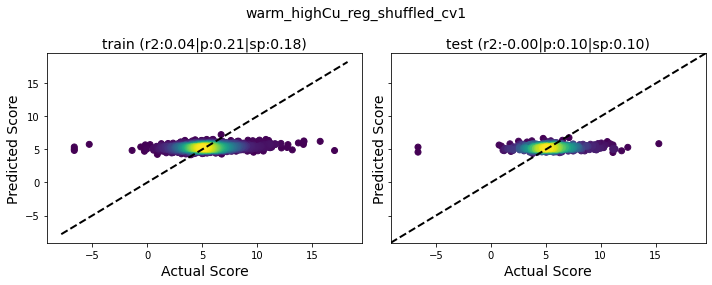

___Running CV2___


E:154 | train loss:2.142 | val loss: 4.442:   3%|▎         | 154/5000 [00:12<06:16, 12.88it/s]

EarlyStopping counter: 125 out of 500


E:279 | train loss:0.892 | val loss: 4.878:   6%|▌         | 280/5000 [00:21<06:06, 12.86it/s]

EarlyStopping counter: 250 out of 500


E:404 | train loss:0.557 | val loss: 4.749:   8%|▊         | 404/5000 [00:31<05:56, 12.89it/s]

EarlyStopping counter: 375 out of 500


E:527 | train loss:0.446 | val loss: 4.642:  11%|█         | 527/5000 [00:41<05:48, 12.82it/s]


EarlyStopping counter: 500 out of 500
Early stopping


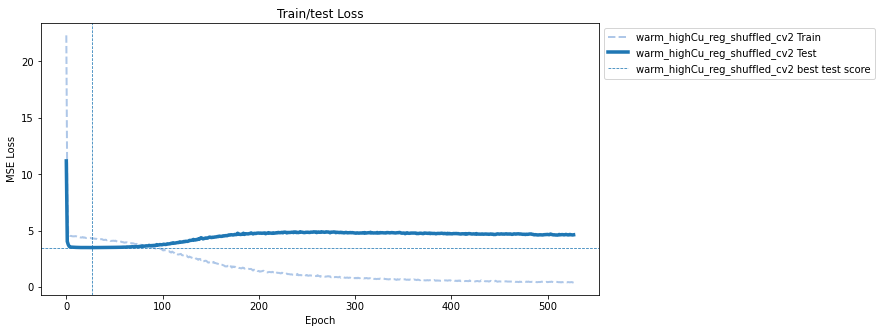

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_highCu_reg_shuffled_cv2
test split
Predicting for warm_highCu_reg_shuffled_cv2


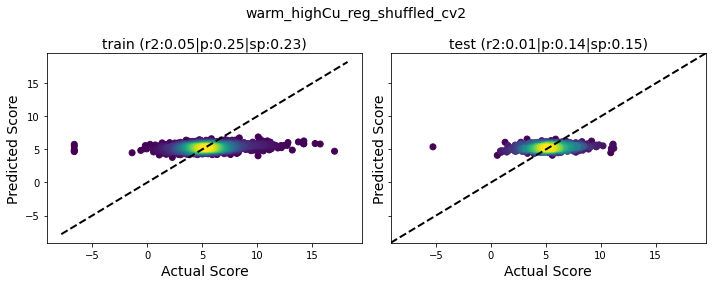

___Running CV3___


E:130 | train loss:2.689 | val loss: 4.888:   3%|▎         | 130/5000 [00:10<06:13, 13.05it/s]

EarlyStopping counter: 125 out of 500


E:255 | train loss:1.129 | val loss: 5.637:   5%|▌         | 256/5000 [00:19<06:04, 13.01it/s]

EarlyStopping counter: 250 out of 500


E:380 | train loss:0.722 | val loss: 5.649:   8%|▊         | 380/5000 [00:29<05:54, 13.02it/s]

EarlyStopping counter: 375 out of 500


E:503 | train loss:0.486 | val loss: 5.410:  10%|█         | 503/5000 [00:38<05:47, 12.92it/s]


EarlyStopping counter: 500 out of 500
Early stopping


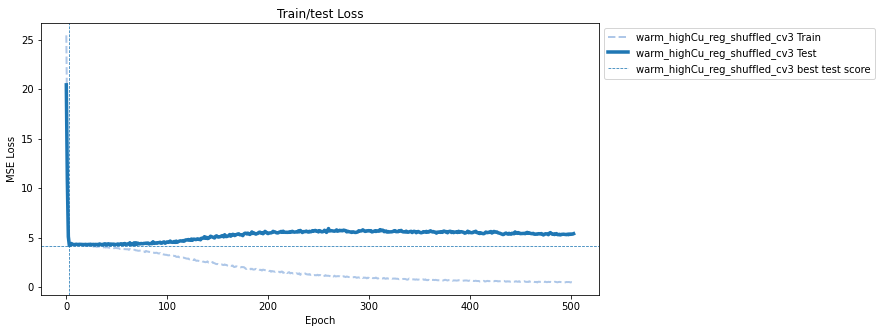

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_highCu_reg_shuffled_cv3
test split
Predicting for warm_highCu_reg_shuffled_cv3


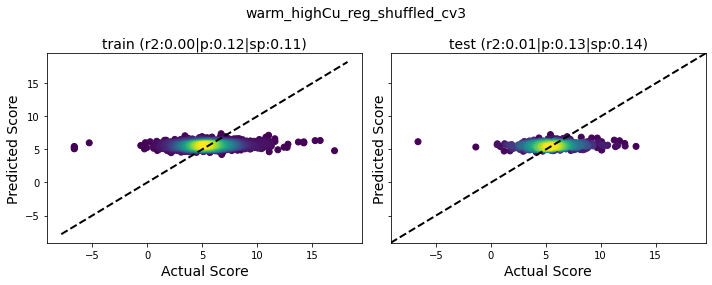

___Running CV4___


E:170 | train loss:1.781 | val loss: 5.953:   3%|▎         | 170/5000 [00:13<06:09, 13.06it/s]

EarlyStopping counter: 125 out of 500


E:295 | train loss:0.857 | val loss: 6.456:   6%|▌         | 296/5000 [00:22<05:59, 13.07it/s]

EarlyStopping counter: 250 out of 500


E:420 | train loss:0.558 | val loss: 6.358:   8%|▊         | 420/5000 [00:32<05:50, 13.06it/s]

EarlyStopping counter: 375 out of 500


E:543 | train loss:0.412 | val loss: 6.044:  11%|█         | 543/5000 [00:41<05:41, 13.03it/s]


EarlyStopping counter: 500 out of 500
Early stopping


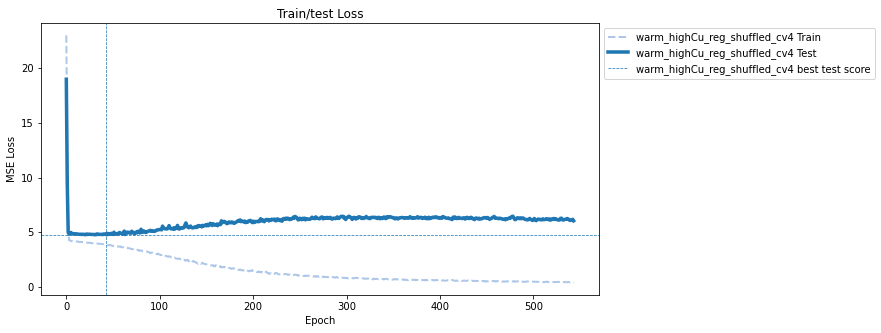

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_highCu_reg_shuffled_cv4
test split
Predicting for warm_highCu_reg_shuffled_cv4


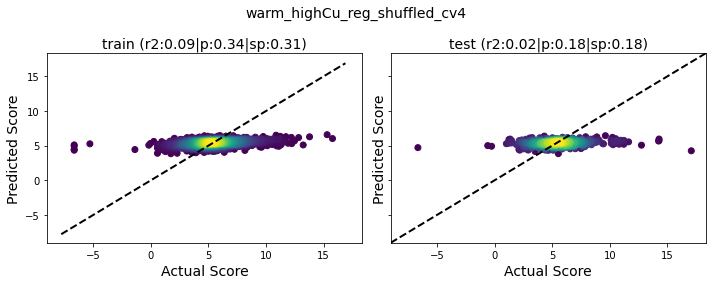

In [39]:
presplit_dir = 'highCu_logTPM_reg_splits'
target_col = 'highCu'
seq_col = 'shuffled_seq'
locus_col = 'locus_tag'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    split_dfs = {
        'train':train_df,
        'test':test_df
    }

    # create data loaders    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    # NO SAMPLER for regression
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_reg = (seq_len,1) # single task regression
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_reg,**m_kwargs)
    model.load_state_dict(model_5org_cls_weights,strict=False)
    model_name = f"warm_highCu_reg_shuffled_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='regression'
    )

    model_res_regr[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.parity_pred_by_split(
        model,
        model_name,
        DEVICE,
        split_dfs,
        locus_col=locus_col,
        seq_col=seq_col,
        target_col=target_col,
        splits=['train','test'],
        #save_file=f"{out_dir}/{model_name}_parity_plot.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "shuffled"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_logTPM_regr'
    p_res_df['start'] = 'model_5org_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs_regr[model_name] = p_res_df

### Compare overall predictions of warm start for regression

In [40]:
all_preds_regr = pd.concat([pred_dfs_regr[x] for x in pred_dfs_regr])
all_preds_regr

model_name  split        r2   pearson  spearman  \
0           warm_highCu_reg_cv0  train  0.153770  0.418345  0.378446   
1           warm_highCu_reg_cv0   test  0.047681  0.221951  0.217179   
0           warm_highCu_reg_cv1  train  0.281386  0.564318  0.501685   
1           warm_highCu_reg_cv1   test  0.055495  0.251498  0.172818   
0           warm_highCu_reg_cv2  train  0.203785  0.500631  0.423010   
1           warm_highCu_reg_cv2   test  0.079245  0.283334  0.294195   
0           warm_highCu_reg_cv3  train  0.046232  0.216172  0.211507   
1           warm_highCu_reg_cv3   test -0.004486  0.118765  0.146603   
0           warm_highCu_reg_cv4  train  0.156360  0.434431  0.392785   
1           warm_highCu_reg_cv4   test  0.064125  0.278778  0.270853   
0  warm_highCu_reg_shuffled_cv0  train  0.057060  0.274447  0.262411   
1  warm_highCu_reg_shuffled_cv0   test  0.006633  0.123014  0.139036   
0  warm_highCu_reg_shuffled_cv1  train  0.038591  0.211462  0.182348   
1  warm_highCu_reg_shuffled_cv1   test -0.001840  0.101880  0.100927   
0  warm_highCu_reg_shuffled_cv2  train  0.048651  0.245589  0.231740   
1  warm_highCu_reg_shuffled_cv2   test  0.013919  0.143260  0.145821   
0  warm_highCu_reg_shuffled_cv3  train  0.002895  0.122774  0.107279   
1  warm_highCu_reg_shuffled_cv3   test  0.012126  0.131004  0.142640   
0  warm_highCu_reg_shuffled_cv4  train  0.092309  0.337067  0.312658   
1  warm_highCu_reg_shuffled_cv4   test  0.021621  0.179556  0.181051   

  model_type  seq_mode  fold                task                   start  \
0        CNN   regular     0  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN   regular     0  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN   regular     1  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN   regular     1  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN   regular     2  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN   regular     2  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN   regular     3  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN   regular     3  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN   regular     4  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN   regular     4  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN  shuffled     0  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN  shuffled     0  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN  shuffled     1  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN  shuffled     1  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN  shuffled     2  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN  shuffled     2  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN  shuffled     3  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN  shuffled     3  highCu_logTPM_regr  model_5org_cls_weights   
0        CNN  shuffled     4  highCu_logTPM_regr  model_5org_cls_weights   
1        CNN  shuffled     4  highCu_logTPM_regr  model_5org_cls_weights   

   best_val_score  epoch_stop  total_time  
0        4.140040          50   42.881878  
1        4.140040          50   42.881878  
0        4.354161          90   45.747236  
1        4.354161          90   45.747236  
0        3.276832          59   43.251061  
1        3.276832          59   43.251061  
0        4.287974           4   38.759571  
1        4.287974           4   38.759571  
0        4.558273          53   42.474678  
1        4.558273          53   42.474678  
0        4.318488          24   40.222766  
1        4.318488          24   40.222766  
0        4.618474          21   39.870385  
1        4.618474          21   39.870385  
0        3.509317          27   41.107881  
1        3.509317          27   41.107881  
0        4.217061           3   38.927338  
1        4.217061           3   38.927338  
0        4.765294          43   41.669045  
1        4.765294          43  

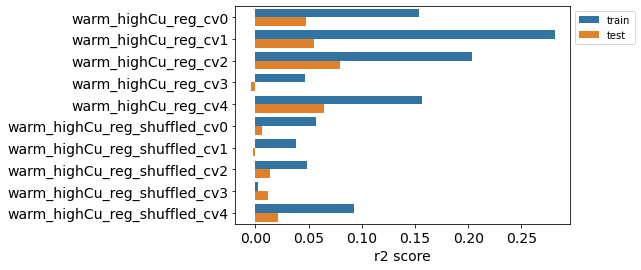

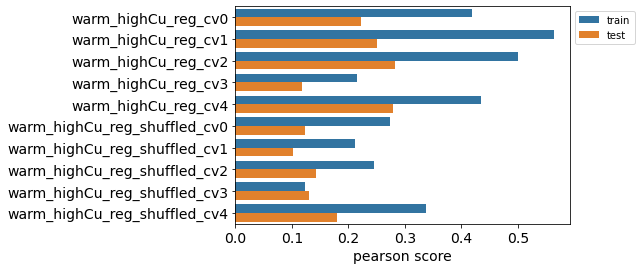

In [41]:
plot_metric(all_preds_regr,'r2')
plot_metric(all_preds_regr,'pearson')

In [42]:
df_train = all_preds_regr[all_preds_regr['split']=='train']
df_test = all_preds_regr[all_preds_regr['split']=='test']

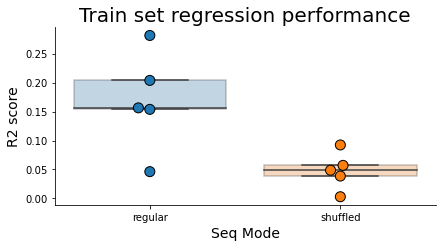

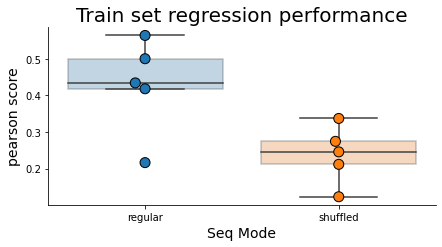

In [43]:
# TRAIN
g = sns.catplot(
    data=df_train, x='seq_mode', y='r2',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='r2',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('R2 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Train set regression performance",fontsize=20)
plt.show()

g = sns.catplot(
    data=df_train, x='seq_mode', y='pearson',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='pearson',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('pearson score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Train set regression performance",fontsize=20)
plt.show()

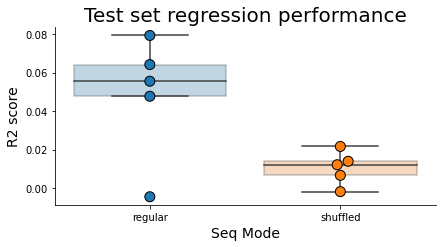

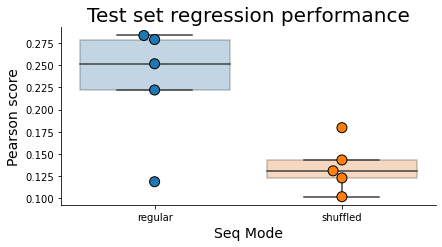

In [44]:
g = sns.catplot(
    data=df_test, x='seq_mode', y='r2',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='r2',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('R2 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set regression performance",fontsize=20)
plt.show()

g = sns.catplot(
    data=df_test, x='seq_mode', y='pearson',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='pearson',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Pearson score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set regression performance",fontsize=20)
plt.show()

In [45]:
regular_r2scores = df_test[df_test['seq_mode']=='regular']['r2'].values
shuffled_r2scores = df_test[df_test['seq_mode']=='shuffled']['r2'].values
print("R2")
print(ttest_ind(regular_r2scores, shuffled_r2scores))

regular_pearsonscores = df_test[df_test['seq_mode']=='regular']['pearson'].values
shuffled_pearsonscores = df_test[df_test['seq_mode']=='shuffled']['pearson'].values
print("Pearson")
print(ttest_ind(regular_pearsonscores, shuffled_pearsonscores))

R2
Ttest_indResult(statistic=2.5707177946557627, pvalue=0.03309059698248906)
Pearson
Ttest_indResult(statistic=2.9061151519725246, pvalue=0.019706087231307536)


In [46]:
print("Mean R2 for regular seqs:",np.mean(regular_r2scores))
print("Mean R2 for shuffled seqs:",np.mean(shuffled_r2scores))
print()
print("Mean Pearson for regular seqs:",np.mean(regular_pearsonscores))
print("Mean Pearson for shuffled seqs:",np.mean(shuffled_pearsonscores))

Mean R2 for regular seqs: 0.048411752569307985
Mean R2 for shuffled seqs: 0.010491522634335393

Mean Pearson for regular seqs: 0.2308653401042764
Mean Pearson for shuffled seqs: 0.13574272134091916


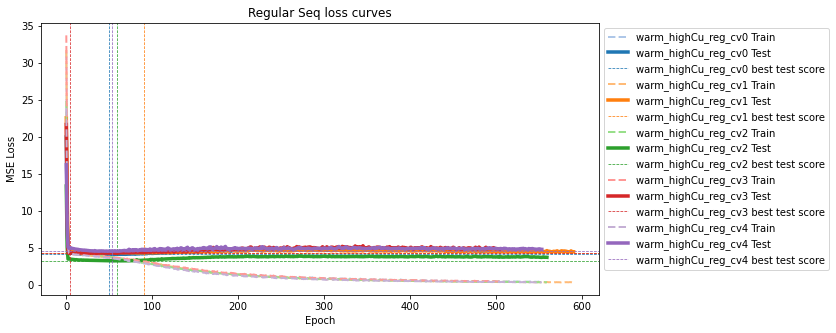

<Figure size 432x288 with 0 Axes>

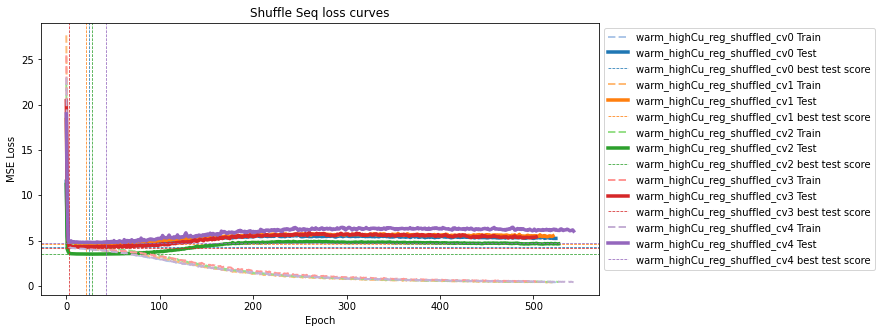

<Figure size 432x288 with 0 Axes>

In [50]:
tu.quick_loss_plot(
    [model_res_regr[x]['data_label'][0] for x in model_res_regr if "shuffle" not in x],
    title="Regular Seq loss curves",
    loss_str = "MSE Loss",
    save_file = 'out_warmStart_highCu_regr/regular_seq_W:5orgCLS_loss_plot.png'
)

tu.quick_loss_plot(
    [model_res_regr[x]['data_label'][0] for x in model_res_regr if "shuffle" in x],
    title="Shuffle Seq loss curves",
    loss_str = "MSE Loss",
    save_file = 'out_warmStart_highCu_regr/shuffle_seq_W:5orgCLS_loss_plot.png'
)

# Warm start with 5G CDS vs UPS classification model

### load 5G UPS/CDS classification model and confirm predictions on it's own data look correct


In [51]:
m_args_5g_ups_cds_cls = (seq_len,2)
m_kwargs = {
    "num_filters1":32,
    "num_filters2":32,
    "kernel_size1":10,
    "kernel_size2":6,
    "conv_pool_size1":2,
    "fc_node_num1":50,
    "fc_node_num2":50,
    "dropout1":0.25
}

saved_5g_ups_cds_cls_filename = 'saved_models/5g_ups_cds_cls_cv0_model_state_dict.pt'
model_5g_ups_cds_cls = m.DNA_2CNN_2FC(*m_args_5g_ups_cds_cls,**m_kwargs)
model_5g_ups_cds_cls.load_state_dict(torch.load(saved_5g_ups_cds_cls_filename))
model_5g_ups_cds_cls


DNA_2CNN_2FC(
  (conv_net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 10), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 6), stride=(1, 1))
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten()
    (8): Linear(in_features=4480, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=50, bias=True)
    (11): ReLU()
    (12): Linear(in_features=50, out_features=2, bias=True)
  )
)

Running predictions for reloaded model_5g_ups_cds_cls


model_name  split  mac_precision  mac_recall    mac_f1  \
0  reloaded model_5g_ups_cds_cls  train        0.96355    0.961404  0.962470   
1  reloaded model_5g_ups_cds_cls   test        0.92006    0.913842  0.916887   

   support  
0    13088  
1     3272

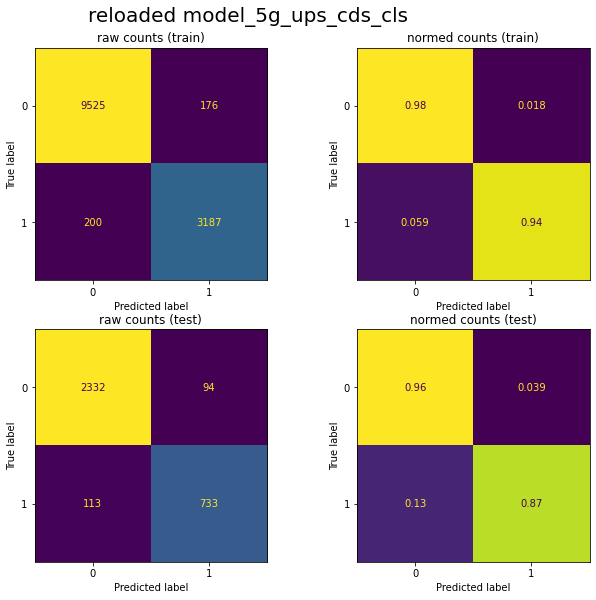

In [52]:
temp_train_df = pd.read_csv(f'data/5g_ups_cds_cls_splits/cv0_train.tsv',sep='\t')
temp_test_df = pd.read_csv(f'data/5g_ups_cds_cls_splits/cv0_test.tsv',sep='\t')

temp_seq_list = [
    (temp_train_df['seq'].values,temp_train_df['seq_type_id'],"train"),
    (temp_test_df['seq'].values,temp_test_df['seq_type_id'],"test")
]

tu.get_confusion_stats(
    model_5g_ups_cds_cls.to(DEVICE),
    'reloaded model_5g_ups_cds_cls',
    temp_seq_list,
    DEVICE,
    title=f"reloaded model_5g_ups_cds_cls",
)

looks good, now extract the relevant layers (all but the last layer)

In [53]:
see_model_layers(model_5g_ups_cds_cls)

('conv_net.0.weight', torch.Size([32, 1, 4, 10]))
('conv_net.0.bias', torch.Size([32]))
('conv_net.4.weight', torch.Size([32, 32, 1, 6]))
('conv_net.4.bias', torch.Size([32]))
('conv_net.8.weight', torch.Size([50, 4480]))
('conv_net.8.bias', torch.Size([50]))
('conv_net.10.weight', torch.Size([50, 50]))
('conv_net.10.bias', torch.Size([50]))
('conv_net.12.weight', torch.Size([2, 50]))
('conv_net.12.bias', torch.Size([2]))


Remove the weight and bias of the final layer, so we can change the prediction task head

In [54]:
# Exclude final layer of model.state_dict 
to_exclude = ['conv_net.12.weight', 'conv_net.12.bias']
model_5g_ups_cds_cls_weights = {k: v for k, v in model_5g_ups_cds_cls.state_dict().items() if k not in to_exclude}
model_5g_ups_cds_cls_weights.keys()

dict_keys(['conv_net.0.weight', 'conv_net.0.bias', 'conv_net.4.weight', 'conv_net.4.bias', 'conv_net.8.weight', 'conv_net.8.bias', 'conv_net.10.weight', 'conv_net.10.bias'])

### cu classification task with 5g cds warm model

___Running CV0___


E:178 | train loss:0.028 | val loss: 0.856:   4%|▎         | 178/5000 [00:14<06:13, 12.92it/s]

EarlyStopping counter: 125 out of 500


E:303 | train loss:0.012 | val loss: 1.023:   6%|▌         | 304/5000 [00:23<06:02, 12.96it/s]

EarlyStopping counter: 250 out of 500


E:428 | train loss:0.003 | val loss: 1.135:   9%|▊         | 428/5000 [00:33<05:53, 12.94it/s]

EarlyStopping counter: 375 out of 500


E:551 | train loss:0.006 | val loss: 1.202:  11%|█         | 551/5000 [00:42<05:46, 12.84it/s]


EarlyStopping counter: 500 out of 500
Early stopping


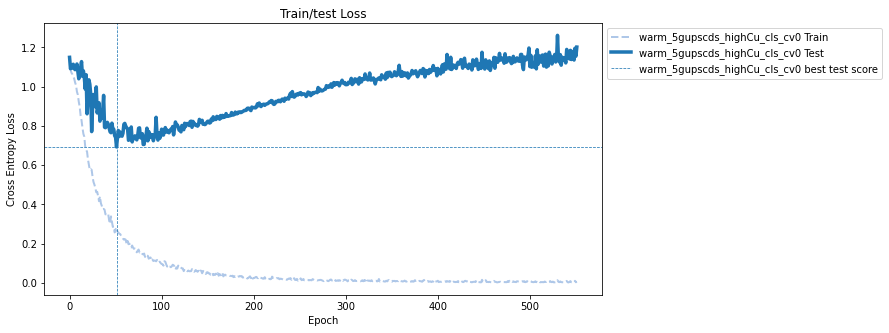

Running predictions for warm_5gupscds_highCu_cls_cv0
___Running CV1___


E:187 | train loss:0.052 | val loss: 0.995:   4%|▍         | 188/5000 [00:14<06:09, 13.02it/s]

EarlyStopping counter: 125 out of 500


E:312 | train loss:0.018 | val loss: 1.189:   6%|▌         | 312/5000 [00:24<06:00, 13.00it/s]

EarlyStopping counter: 250 out of 500


E:437 | train loss:0.010 | val loss: 1.351:   9%|▉         | 438/5000 [00:33<05:51, 12.96it/s]

EarlyStopping counter: 375 out of 500


E:560 | train loss:0.004 | val loss: 1.450:  11%|█         | 560/5000 [00:43<05:42, 12.96it/s]


EarlyStopping counter: 500 out of 500
Early stopping


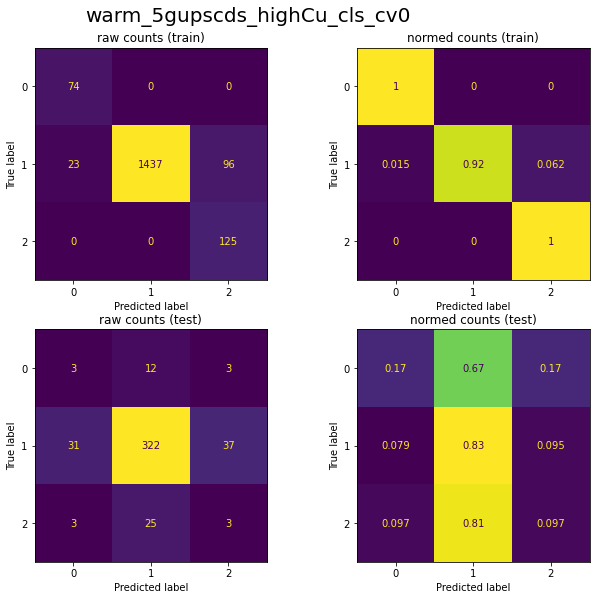

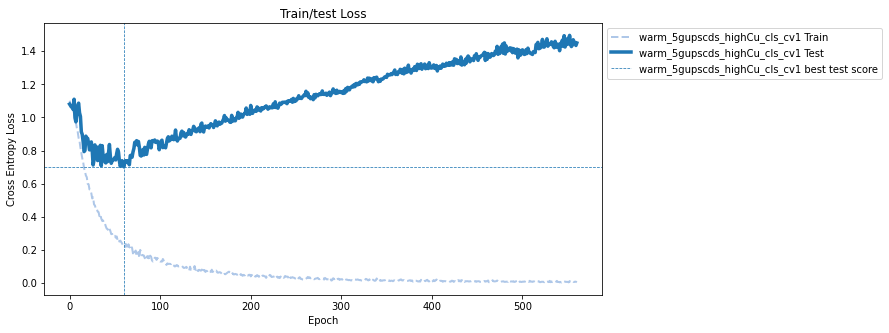

Running predictions for warm_5gupscds_highCu_cls_cv1
___Running CV2___


E:198 | train loss:0.024 | val loss: 0.926:   4%|▍         | 198/5000 [00:15<06:05, 13.14it/s]

EarlyStopping counter: 125 out of 500


E:323 | train loss:0.010 | val loss: 1.143:   6%|▋         | 324/5000 [00:24<05:56, 13.13it/s]

EarlyStopping counter: 250 out of 500


E:448 | train loss:0.003 | val loss: 1.180:   9%|▉         | 448/5000 [00:34<05:47, 13.08it/s]

EarlyStopping counter: 375 out of 500


E:571 | train loss:0.005 | val loss: 1.227:  11%|█▏        | 571/5000 [00:43<05:39, 13.05it/s]


EarlyStopping counter: 500 out of 500
Early stopping


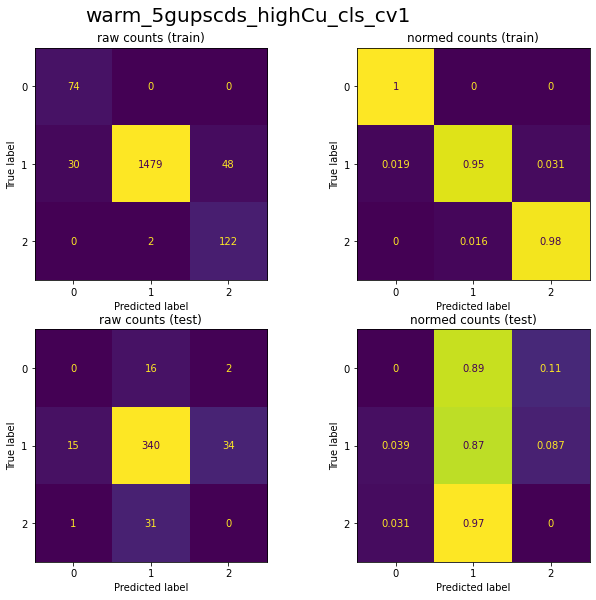

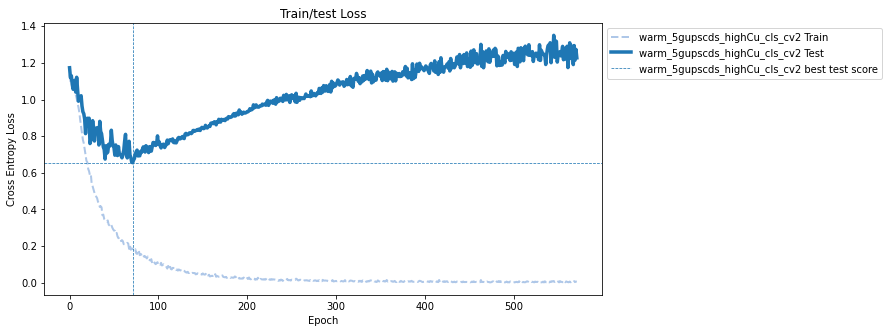

Running predictions for warm_5gupscds_highCu_cls_cv2
___Running CV3___


E:202 | train loss:0.018 | val loss: 0.881:   4%|▍         | 202/5000 [00:17<06:01, 13.26it/s]

EarlyStopping counter: 125 out of 500


E:327 | train loss:0.003 | val loss: 0.994:   7%|▋         | 328/5000 [00:27<05:52, 13.27it/s]

EarlyStopping counter: 250 out of 500


E:452 | train loss:0.006 | val loss: 1.109:   9%|▉         | 452/5000 [00:36<05:42, 13.29it/s]

EarlyStopping counter: 375 out of 500


E:575 | train loss:0.001 | val loss: 1.138:  12%|█▏        | 575/5000 [00:45<05:51, 12.58it/s]


EarlyStopping counter: 500 out of 500
Early stopping


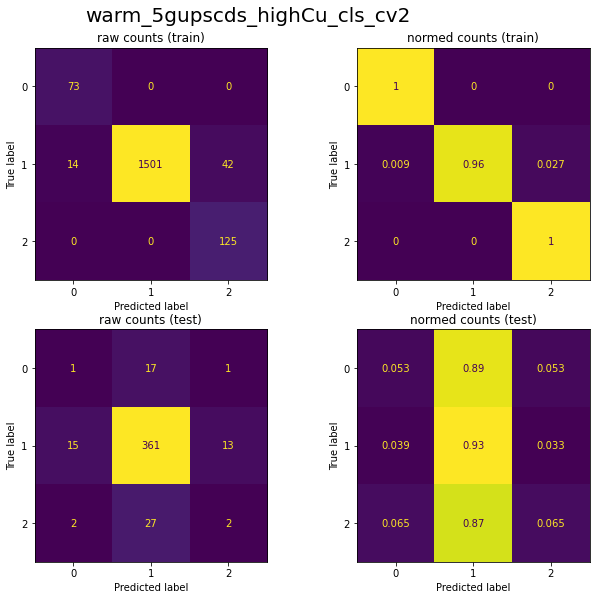

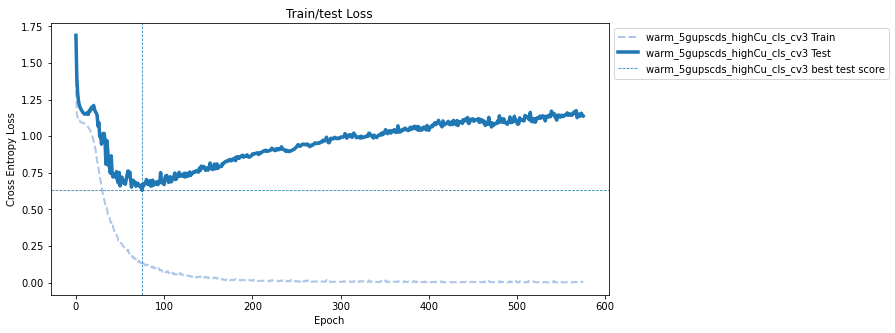

Running predictions for warm_5gupscds_highCu_cls_cv3
___Running CV4___


E:175 | train loss:0.043 | val loss: 0.872:   4%|▎         | 176/5000 [00:13<06:04, 13.23it/s]

EarlyStopping counter: 125 out of 500


E:300 | train loss:0.017 | val loss: 1.041:   6%|▌         | 300/5000 [00:22<05:52, 13.34it/s]

EarlyStopping counter: 250 out of 500


E:425 | train loss:0.005 | val loss: 1.186:   9%|▊         | 426/5000 [00:32<05:43, 13.32it/s]

EarlyStopping counter: 375 out of 500


E:548 | train loss:0.003 | val loss: 1.239:  11%|█         | 548/5000 [00:41<05:34, 13.30it/s]


EarlyStopping counter: 500 out of 500
Early stopping


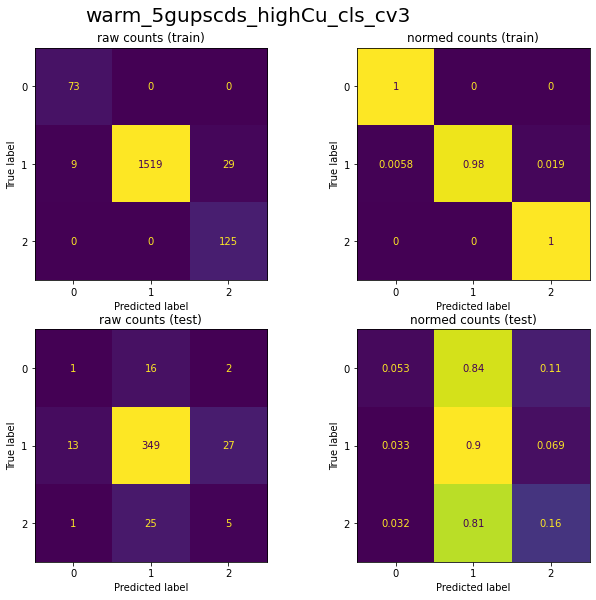

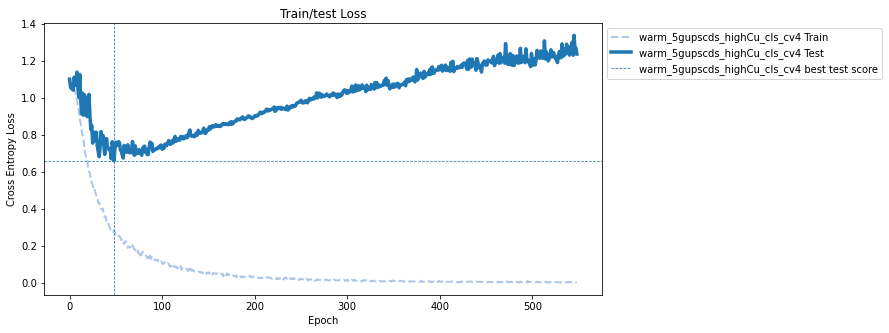

Running predictions for warm_5gupscds_highCu_cls_cv4


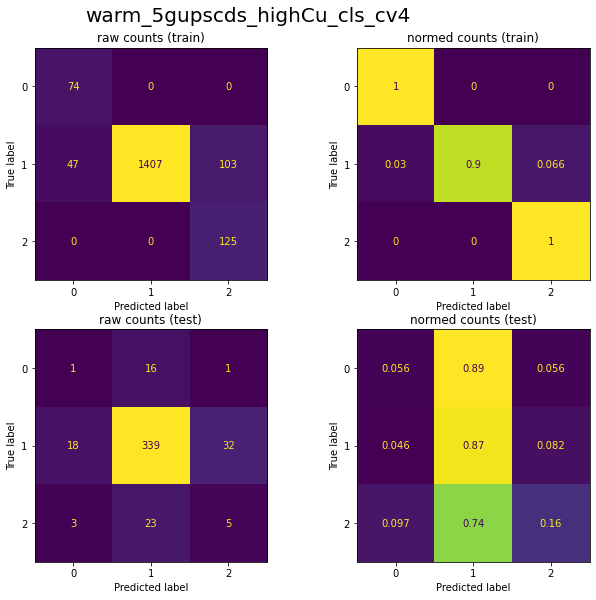

In [55]:
presplit_dir = 'highCu_cls_splits'
target_col = 'highCu_reg_UD'
seq_col = 'upstream_region'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    seq_list = [
        (train_df[seq_col].values,train_df[target_col],"train"),
        (test_df[seq_col].values,test_df[target_col],"test")
    ]

    # create data loaders
    sampler = tu.make_weighted_sampler(train_df,target_col)
    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    sampler=sampler,
                    shuffle=False,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_cls = (seq_len,3)
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_cls,**m_kwargs)
    model.load_state_dict(model_5g_ups_cds_cls_weights,strict=False)
    model_name = f"warm_5gupscds_highCu_cls_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='classification'
    )

    model_res[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.get_confusion_stats(
        t_res['model'],
        t_res['model_name'],
        seq_list,
        DEVICE,
        title=f"{t_res['model_name']}",
        #save_file=f"{out_dir}/{model_name}_confmat.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "regular"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_cls'
    p_res_df['start'] = 'model_5g_ups_cds_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs[model_name] = p_res_df

### shuffled warm 5g ups cds

___Running CV0___


E:194 | train loss:0.038 | val loss: 0.970:   4%|▍         | 195/5000 [00:15<06:11, 12.94it/s]

EarlyStopping counter: 125 out of 500


E:319 | train loss:0.013 | val loss: 1.136:   6%|▋         | 319/5000 [00:24<06:00, 13.00it/s]

EarlyStopping counter: 250 out of 500


E:444 | train loss:0.005 | val loss: 1.222:   9%|▉         | 445/5000 [00:34<05:50, 12.98it/s]

EarlyStopping counter: 375 out of 500


E:567 | train loss:0.005 | val loss: 1.352:  11%|█▏        | 567/5000 [00:43<05:42, 12.94it/s]


EarlyStopping counter: 500 out of 500
Early stopping


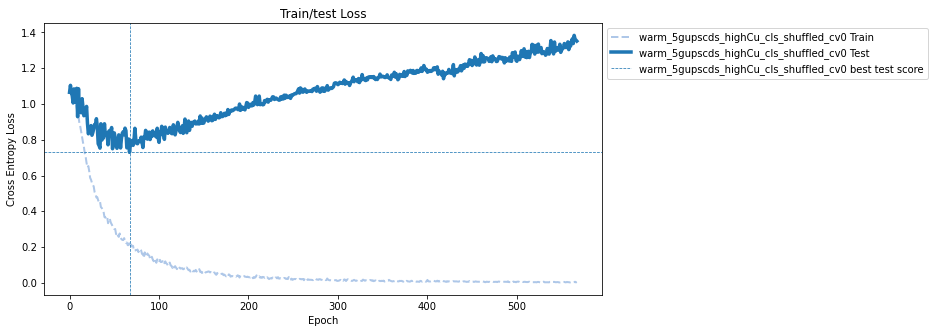

Running predictions for warm_5gupscds_highCu_cls_shuffled_cv0
___Running CV1___


E:172 | train loss:0.031 | val loss: 0.987:   3%|▎         | 172/5000 [00:13<06:09, 13.05it/s]

EarlyStopping counter: 125 out of 500


E:297 | train loss:0.010 | val loss: 1.176:   6%|▌         | 298/5000 [00:22<05:59, 13.09it/s]

EarlyStopping counter: 250 out of 500


E:422 | train loss:0.005 | val loss: 1.316:   8%|▊         | 422/5000 [00:32<05:50, 13.06it/s]

EarlyStopping counter: 375 out of 500


E:545 | train loss:0.003 | val loss: 1.483:  11%|█         | 545/5000 [00:41<05:41, 13.05it/s]


EarlyStopping counter: 500 out of 500
Early stopping


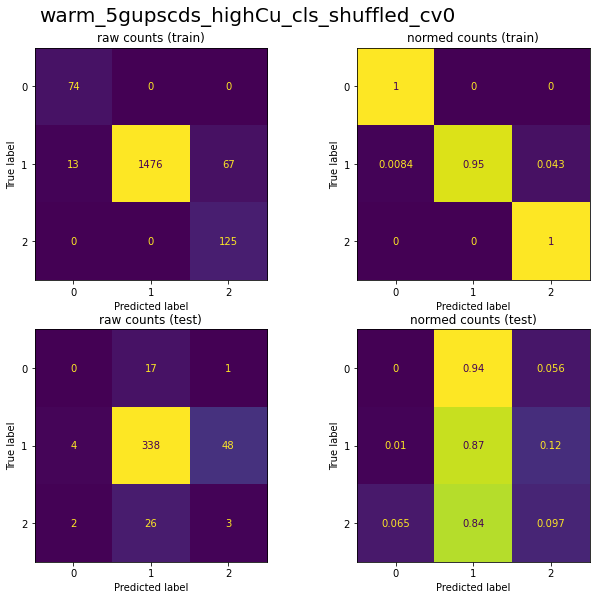

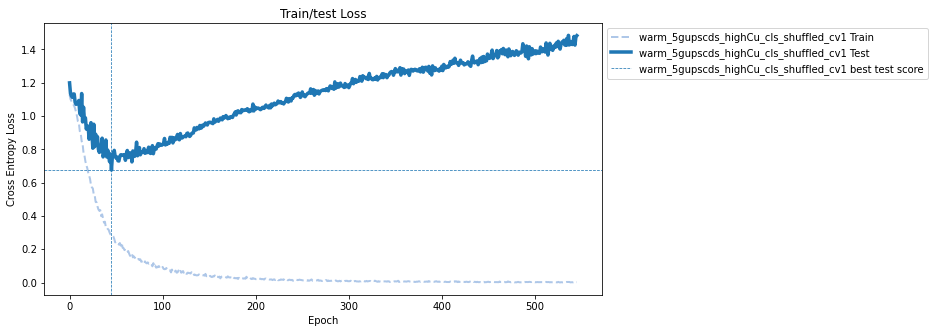

Running predictions for warm_5gupscds_highCu_cls_shuffled_cv1
___Running CV2___


E:183 | train loss:0.040 | val loss: 1.008:   4%|▎         | 183/5000 [00:14<06:08, 13.07it/s]

EarlyStopping counter: 125 out of 500


E:308 | train loss:0.014 | val loss: 1.214:   6%|▌         | 309/5000 [00:23<05:58, 13.09it/s]

EarlyStopping counter: 250 out of 500


E:433 | train loss:0.009 | val loss: 1.328:   9%|▊         | 433/5000 [00:33<05:49, 13.08it/s]

EarlyStopping counter: 375 out of 500


E:556 | train loss:0.002 | val loss: 1.423:  11%|█         | 556/5000 [00:42<05:40, 13.03it/s]


EarlyStopping counter: 500 out of 500
Early stopping


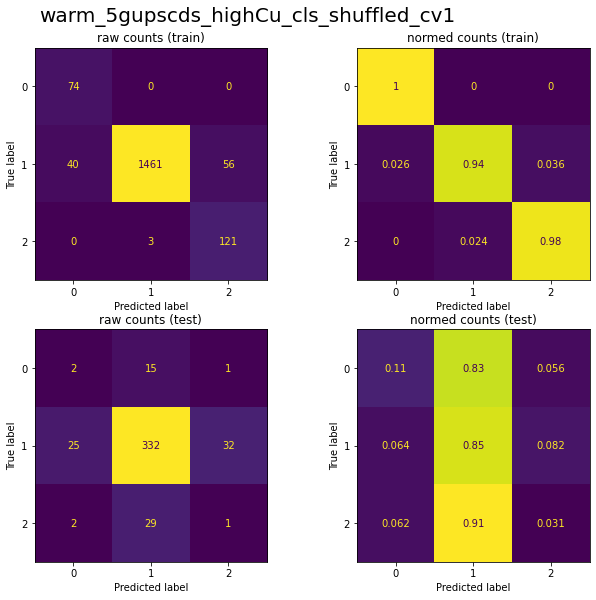

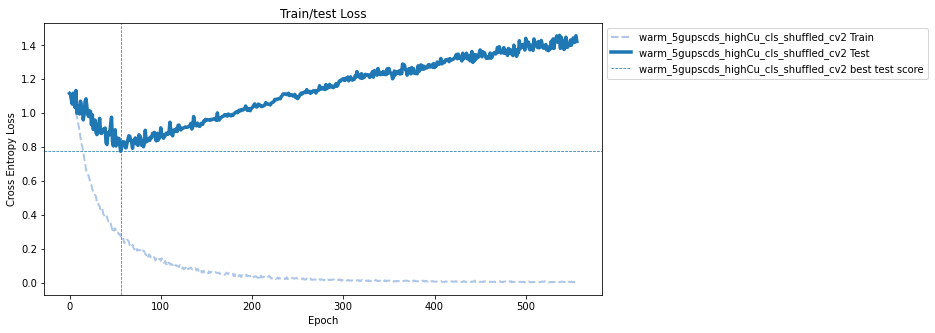

Running predictions for warm_5gupscds_highCu_cls_shuffled_cv2
___Running CV3___


E:187 | train loss:0.039 | val loss: 0.782:   4%|▍         | 188/5000 [00:14<06:05, 13.17it/s]

EarlyStopping counter: 125 out of 500


E:312 | train loss:0.012 | val loss: 0.922:   6%|▌         | 312/5000 [00:23<05:55, 13.17it/s]

EarlyStopping counter: 250 out of 500


E:437 | train loss:0.004 | val loss: 1.061:   9%|▉         | 438/5000 [00:33<05:46, 13.18it/s]

EarlyStopping counter: 375 out of 500


E:560 | train loss:0.004 | val loss: 1.099:  11%|█         | 560/5000 [00:42<05:38, 13.13it/s]


EarlyStopping counter: 500 out of 500
Early stopping


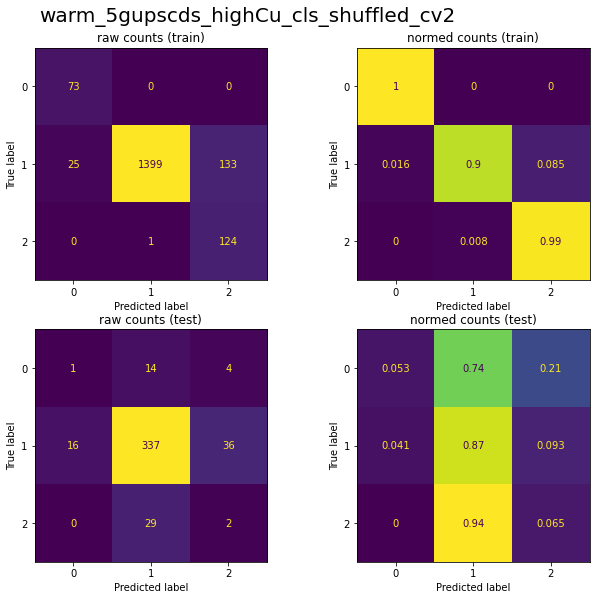

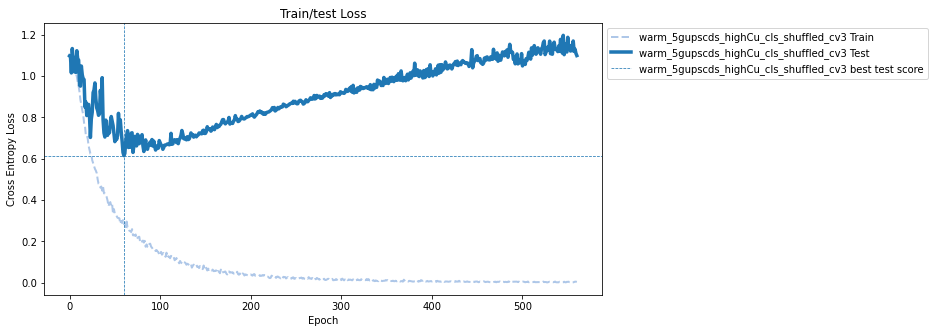

Running predictions for warm_5gupscds_highCu_cls_shuffled_cv3
___Running CV4___


E:150 | train loss:0.079 | val loss: 0.919:   3%|▎         | 150/5000 [00:11<06:16, 12.87it/s]

EarlyStopping counter: 125 out of 500


E:275 | train loss:0.026 | val loss: 1.109:   6%|▌         | 276/5000 [00:21<06:05, 12.91it/s]

EarlyStopping counter: 250 out of 500


E:400 | train loss:0.011 | val loss: 1.265:   8%|▊         | 400/5000 [00:31<05:55, 12.94it/s]

EarlyStopping counter: 375 out of 500


E:523 | train loss:0.009 | val loss: 1.392:  10%|█         | 523/5000 [00:40<05:49, 12.82it/s]


EarlyStopping counter: 500 out of 500
Early stopping


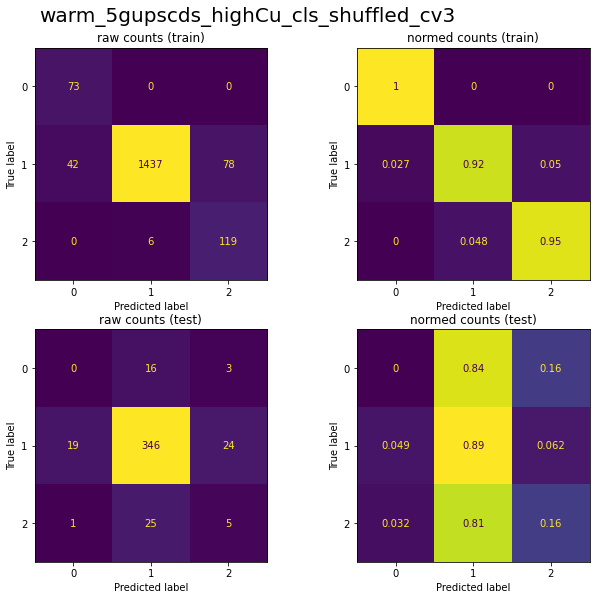

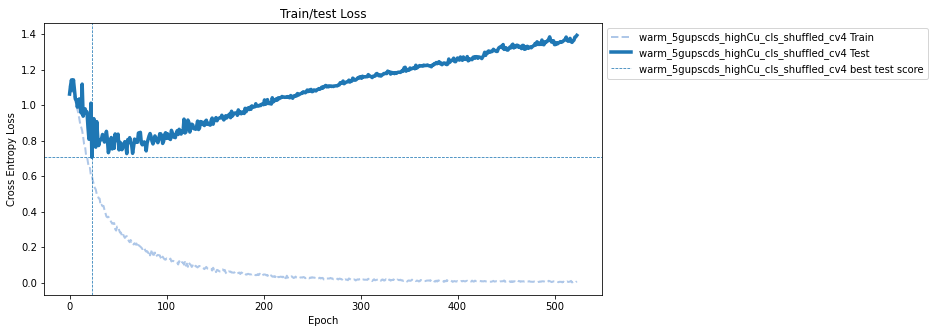

Running predictions for warm_5gupscds_highCu_cls_shuffled_cv4


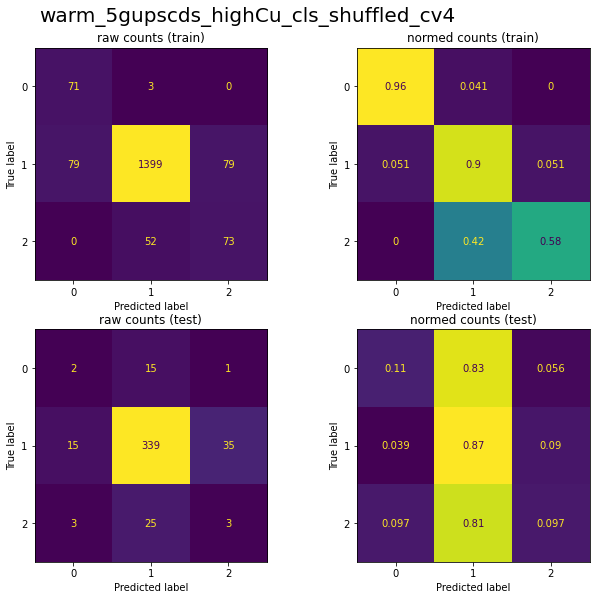

In [56]:
presplit_dir = 'highCu_cls_splits'
target_col = 'highCu_reg_UD'
seq_col = 'shuffled_seq'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    seq_list = [
        (train_df[seq_col].values,train_df[target_col],"train"),
        (test_df[seq_col].values,test_df[target_col],"test")
    ]

    # create data loaders
    sampler = tu.make_weighted_sampler(train_df,target_col)
    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    sampler=sampler,
                    shuffle=False,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_cls = (seq_len,3)
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_cls,**m_kwargs)
    model.load_state_dict(model_5g_ups_cds_cls_weights,strict=False)
    model_name = f"warm_5gupscds_highCu_cls_shuffled_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='classification'
    )

    model_res[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.get_confusion_stats(
        t_res['model'],
        t_res['model_name'],
        seq_list,
        DEVICE,
        title=f"{t_res['model_name']}",
        #save_file=f"{out_dir}/{model_name}_confmat.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "shuffled"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_cls'
    p_res_df['start'] = 'model_5g_ups_cds_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs[model_name] = p_res_df

### check results from warm ups/cds cls for cu cls

In [57]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

model_name  split  mac_precision  mac_recall  \
0                    warm_highCu_cls_cv0  train       0.816480    0.983933   
1                    warm_highCu_cls_cv0   test       0.378253    0.394789   
0                    warm_highCu_cls_cv1  train       0.792759    0.975380   
1                    warm_highCu_cls_cv1   test       0.315348    0.319891   
0                    warm_highCu_cls_cv2  train       0.754195    0.970242   
1                    warm_highCu_cls_cv2   test       0.372739    0.370835   
0                    warm_highCu_cls_cv3  train       0.802996    0.982659   
1                    warm_highCu_cls_cv3   test       0.316979    0.317071   
0                    warm_highCu_cls_cv4  train       0.799735    0.981589   
1                    warm_highCu_cls_cv4   test       0.332261    0.332226   
0           warm_highCu_cls_shuffled_cv0  train       0.866021    0.990146   
1           warm_highCu_cls_shuffled_cv0   test       0.322119    0.320154   
0           warm_highCu_cls_shuffled_cv1  train       0.774867    0.974071   
1           warm_highCu_cls_shuffled_cv1   test       0.335637    0.337808   
0           warm_highCu_cls_shuffled_cv2  train       0.712064    0.956364   
1           warm_highCu_cls_shuffled_cv2   test       0.333620    0.333435   
0           warm_highCu_cls_shuffled_cv3  train       0.883321    0.990366   
1           warm_highCu_cls_shuffled_cv3   test       0.378778    0.360856   
0           warm_highCu_cls_shuffled_cv4  train       0.880334    0.990794   
1           warm_highCu_cls_shuffled_cv4   test       0.311412    0.318379   
0           warm_5gupscds_highCu_cls_cv0  train       0.776166    0.974507   
1           warm_5gupscds_highCu_cls_cv0   test       0.349261    0.363027   
0           warm_5gupscds_highCu_cls_cv1  train       0.809278    0.977925   
1           warm_5gupscds_highCu_cls_cv1   test       0.292851    0.291345   
0           warm_5gupscds_highCu_cls_cv2  train       0.862528    0.988011   
1           warm_5gupscds_highCu_cls_cv2   test       0.357305    0.348389   
0           warm_5gupscds_highCu_cls_cv3  train       0.900644    0.991865   
1           warm_5gupscds_highCu_cls_cv3   test       0.369532    0.370365   
0           warm_5gupscds_highCu_cls_cv4  train       0.719939    0.967887   
1           warm_5gupscds_highCu_cls_cv4   test       0.357953    0.362770   
0  warm_5gupscds_highCu_cls_shuffled_cv0  train       0.833872    0.982862   
1  warm_5gupscds_highCu_cls_shuffled_cv0   test       0.314944    0.321147   
0  warm_5gupscds_highCu_cls_shuffled_cv1  train       0.776896    0.971383   
1  warm_5gupscds_highCu_cls_shuffled_cv1   test       0.327119    0.331944   
0  warm_5gupscds_highCu_cls_shuffled_cv2  train       0.742225    0.963508   
1  warm_5gupscds_highCu_cls_shuffled_cv2   test       0.331095    0.327824   
0  warm_5gupscds_highCu_cls_shuffled_cv3  train       0.744895    0.958310   
1  warm_5gupscds_highCu_cls_shuffled_cv3   test       0.350102    0.350250   
0  warm_5gupscds_highCu_cls_shuffled_cv4  train       0.638590    0.813994   
1  warm_5gupscds_highCu_cls_shuffled_cv4   test       0.357127    0.359784   

     mac_f1  support model_type  seq_mode  fold        task  \
0  0.885352     1755        CNN   regular     0  highCu_cls   
1  0.383894      439        CNN   regular     0  highCu_cls   
0  0.859597     1755        CNN   regular     1  highCu_cls   
1  0.317602      439        CNN   regular     1  highCu_cls   
0  0.830273     1755        CNN   regular     2  highCu_cls   
1  0.364727      439        CNN   regular     2  highCu_cls   
0  0.875385     1755        CNN   regular     3  highCu_cls   
1  0.316153      439        CNN   regular     3  highCu_cls   
0  0.872695     1756        CNN   regular     4  highCu_cls   
1  0.332080      438        CNN   regular     4  highCu_cls   
0  0.918769     1755        CNN  shuffled     0  highCu_cls   
1  0.317954      439        CNN  shuffled     0  highCu_cls   
0  0.851587 

In [58]:
# get predictions from just the 2nd warm start option (ups_cds_cls)
warm2_preds = pd.concat([pred_dfs[x] for x in pred_dfs if 'ups' in x])
warm2_preds

model_name  split  mac_precision  mac_recall  \
0           warm_5gupscds_highCu_cls_cv0  train       0.776166    0.974507   
1           warm_5gupscds_highCu_cls_cv0   test       0.349261    0.363027   
0           warm_5gupscds_highCu_cls_cv1  train       0.809278    0.977925   
1           warm_5gupscds_highCu_cls_cv1   test       0.292851    0.291345   
0           warm_5gupscds_highCu_cls_cv2  train       0.862528    0.988011   
1           warm_5gupscds_highCu_cls_cv2   test       0.357305    0.348389   
0           warm_5gupscds_highCu_cls_cv3  train       0.900644    0.991865   
1           warm_5gupscds_highCu_cls_cv3   test       0.369532    0.370365   
0           warm_5gupscds_highCu_cls_cv4  train       0.719939    0.967887   
1           warm_5gupscds_highCu_cls_cv4   test       0.357953    0.362770   
0  warm_5gupscds_highCu_cls_shuffled_cv0  train       0.833872    0.982862   
1  warm_5gupscds_highCu_cls_shuffled_cv0   test       0.314944    0.321147   
0  warm_5gupscds_highCu_cls_shuffled_cv1  train       0.776896    0.971383   
1  warm_5gupscds_highCu_cls_shuffled_cv1   test       0.327119    0.331944   
0  warm_5gupscds_highCu_cls_shuffled_cv2  train       0.742225    0.963508   
1  warm_5gupscds_highCu_cls_shuffled_cv2   test       0.331095    0.327824   
0  warm_5gupscds_highCu_cls_shuffled_cv3  train       0.744895    0.958310   
1  warm_5gupscds_highCu_cls_shuffled_cv3   test       0.350102    0.350250   
0  warm_5gupscds_highCu_cls_shuffled_cv4  train       0.638590    0.813994   
1  warm_5gupscds_highCu_cls_shuffled_cv4   test       0.357127    0.359784   

     mac_f1  support model_type  seq_mode  fold        task  \
0  0.849427     1755        CNN   regular     0  highCu_cls   
1  0.349995      439        CNN   regular     0  highCu_cls   
0  0.878353     1755        CNN   regular     1  highCu_cls   
1  0.292096      439        CNN   regular     1  highCu_cls   
0  0.916784     1755        CNN   regular     2  highCu_cls   
1  0.349493      439        CNN   regular     2  highCu_cls   
0  0.941880     1755        CNN   regular     3  highCu_cls   
1  0.369563      439        CNN   regular     3  highCu_cls   
0  0.805527     1756        CNN   regular     4  highCu_cls   
1  0.359630      438        CNN   regular     4  highCu_cls   
0  0.893838     1755        CNN  shuffled     0  highCu_cls   
1  0.316358      439        CNN  shuffled     0  highCu_cls   
0  0.852817     1755        CNN  shuffled     1  highCu_cls   
1  0.327794      439        CNN  shuffled     1  highCu_cls   
0  0.816415     1755        CNN  shuffled     2  highCu_cls   
1  0.328938      439        CNN  shuffled     2  highCu_cls   
0  0.824575     1755        CNN  shuffled     3  highCu_cls   
1  0.350161      439        CNN  shuffled     3  highCu_cls   
0  0.696755     1756        CNN  shuffled     4  highCu_cls   
1  0.357930      438        CNN  shuffled     4  highCu_cls   

                          start  best_val_score  epoch_stop  total_time  
0  model_5g_ups_cds_cls_weights        0.692740          51   42.930526  
1  model_5g_ups_cds_cls_weights        0.692740          51   42.930526  
0  model_5g_ups_cds_cls_weights        0.701312          60   43.201255  
1  model_5g_ups_cds_cls_weights        0.701312          60   43.201255  
0  model_5g_ups_cds_cls_weights        0.655163          71   43.768897  
1  model_5g_ups_cds_cls_weights        0.655163          71   43.768897  
0  model_5g_ups_cds_cls_weights        0.629856          75   45.704829  
1  model_5g_ups_cds_cls_weights        0.629856          75   45.704829  
0  model_5g_ups_cds_cls_weights        0.660753          48   41.220877  
1  model_5g_ups_cds_cls_weights        0.660753          48   41.220877  
0  model_5g_ups_cds_cls_weights        0.729502          67   43.834872  
1  model_5g_ups_cds_cls_weights        0.729502          67   43.834872  
0  model_5g_ups_cds_cls_weights        0.675998          45   41.760314  
1  model_5g_ups_cds_cls_weights

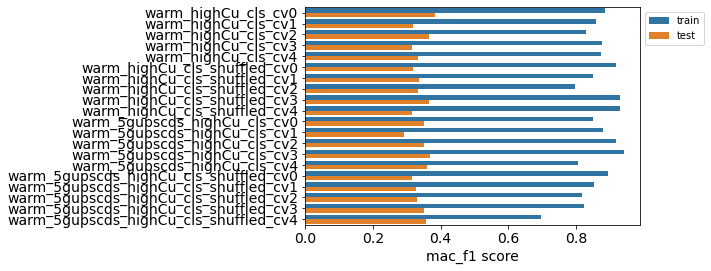

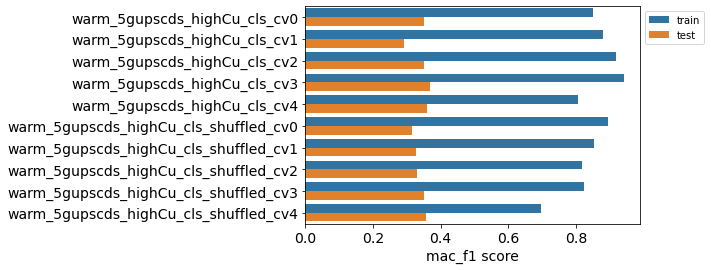

In [59]:
plot_metric(all_preds,'mac_f1')
plot_metric(warm2_preds,'mac_f1')


In [60]:
def check_pred_score_dist(pred_df):
    df_train = pred_df[pred_df['split']=='train']
    df_test = pred_df[pred_df['split']=='test']
    
    # TRAIN plot
    g = sns.catplot(
        data=df_train, x='seq_mode', y='mac_f1',
        kind='box',
        boxprops=dict(alpha=.3),height=3,aspect=4/2
    )
    g.map_dataframe(sns.swarmplot, 
                    x='seq_mode', y='mac_f1',
                    size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

    for ax in g.axes.flatten():
        #ax.set_xlabel('Dataset size', fontsize=14)
        ax.set_ylabel('Macro F1 score', fontsize=14)
    plt.xlabel("Seq Mode",fontsize=14)
    plt.title("Train set classification performance",fontsize=20)
    plt.show()
    
    # TEST plot
    g = sns.catplot(
        data=df_test, x='seq_mode', y='mac_f1',
        kind='box',
        boxprops=dict(alpha=.3),height=3,aspect=4/2
    )
    g.map_dataframe(sns.swarmplot, 
                    x='seq_mode', y='mac_f1',
                    size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

    for ax in g.axes.flatten():
        #ax.set_xlabel('Dataset size', fontsize=14)
        ax.set_ylabel('Macro F1 score', fontsize=14)
    plt.xlabel("Seq Mode",fontsize=14)
    plt.title("Test set classification performance",fontsize=20)
    plt.show()
    
    
    # t test
    regular_scores = df_test[df_test['seq_mode']=='regular']['mac_f1'].values
    shuffled_scores = df_test[df_test['seq_mode']=='shuffled']['mac_f1'].values
    print("T-test:",ttest_ind(regular_scores, shuffled_scores))
    print()
    print("Mean Mac F1 for regular seqs:",np.mean(regular_scores))
    print("Mean Mac F1 for shuffled seqs:",np.mean(shuffled_scores))
    
    

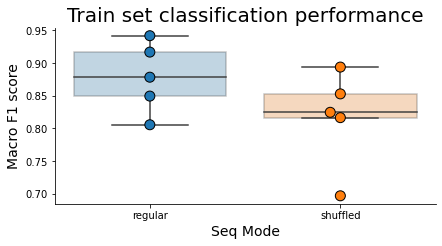

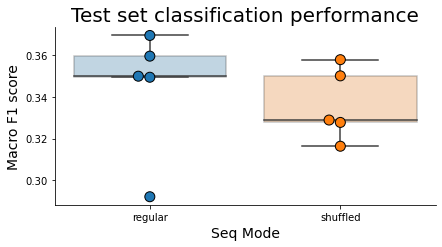

T-test: Ttest_indResult(statistic=0.5089848246576133, pvalue=0.6245006887656106)

Mean Mac F1 for regular seqs: 0.34415568820870746
Mean Mac F1 for shuffled seqs: 0.3362361012630347


In [61]:
check_pred_score_dist(warm2_preds)

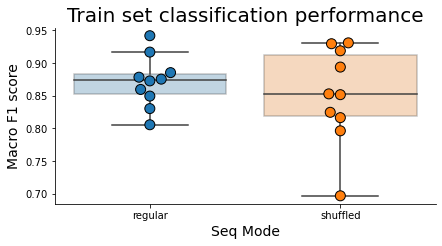

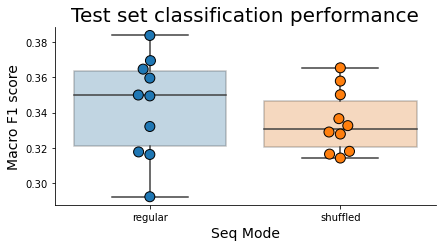

T-test: Ttest_indResult(statistic=0.8229517088716177, pvalue=0.4213048767134866)

Mean Mac F1 for regular seqs: 0.3435234349191577
Mean Mac F1 for shuffled seqs: 0.33478546330383724


In [62]:
check_pred_score_dist(all_preds)

## Lastly, try warm start from UPS/CDS classification for the regression task

___Running CV0___


E:168 | train loss:1.817 | val loss: 4.703:   3%|▎         | 168/5000 [00:12<06:00, 13.39it/s]

EarlyStopping counter: 125 out of 500


E:293 | train loss:0.849 | val loss: 4.750:   6%|▌         | 294/5000 [00:22<05:54, 13.27it/s]

EarlyStopping counter: 250 out of 500


E:418 | train loss:0.513 | val loss: 4.652:   8%|▊         | 418/5000 [00:31<05:41, 13.40it/s]

EarlyStopping counter: 375 out of 500


E:541 | train loss:0.394 | val loss: 4.677:  11%|█         | 541/5000 [00:40<05:36, 13.27it/s]


EarlyStopping counter: 500 out of 500
Early stopping


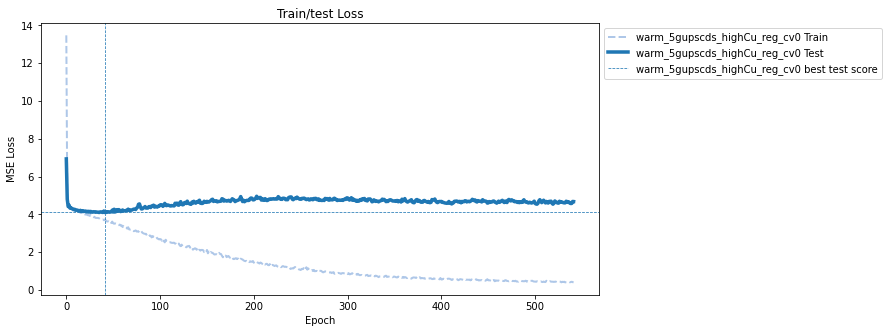

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_5gupscds_highCu_reg_cv0
test split
Predicting for warm_5gupscds_highCu_reg_cv0


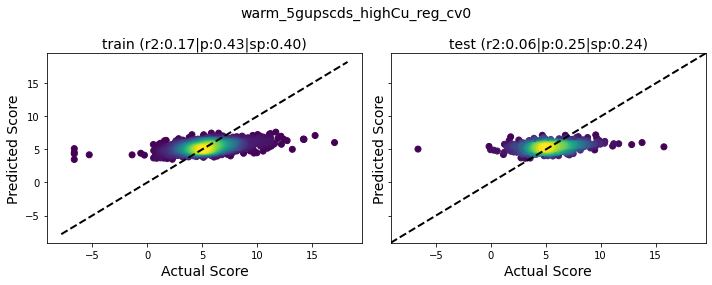

___Running CV1___


E:211 | train loss:2.041 | val loss: 4.950:   4%|▍         | 212/5000 [00:16<06:04, 13.12it/s]

EarlyStopping counter: 125 out of 500


E:336 | train loss:1.017 | val loss: 5.248:   7%|▋         | 336/5000 [00:25<05:57, 13.06it/s]

EarlyStopping counter: 250 out of 500


E:461 | train loss:0.668 | val loss: 4.968:   9%|▉         | 462/5000 [00:35<05:54, 12.81it/s]

EarlyStopping counter: 375 out of 500


E:584 | train loss:0.474 | val loss: 4.869:  12%|█▏        | 584/5000 [00:44<05:39, 13.03it/s]


EarlyStopping counter: 500 out of 500
Early stopping


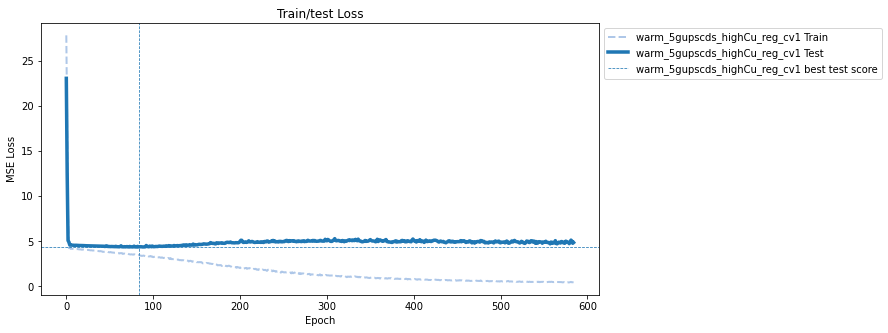

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_5gupscds_highCu_reg_cv1
test split
Predicting for warm_5gupscds_highCu_reg_cv1


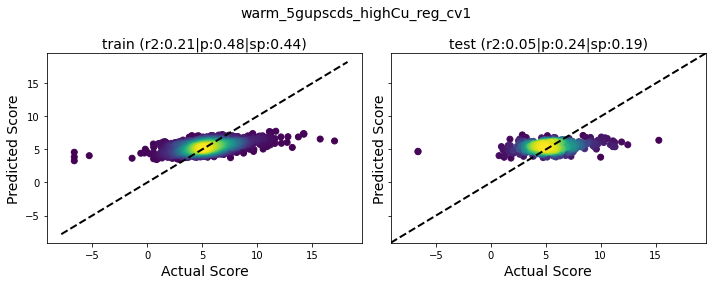

___Running CV2___


E:191 | train loss:2.315 | val loss: 3.734:   4%|▍         | 192/5000 [00:14<06:08, 13.04it/s]

EarlyStopping counter: 125 out of 500


E:316 | train loss:1.191 | val loss: 3.970:   6%|▋         | 316/5000 [00:24<05:58, 13.08it/s]

EarlyStopping counter: 250 out of 500


E:441 | train loss:0.678 | val loss: 3.924:   9%|▉         | 442/5000 [00:33<05:49, 13.06it/s]

EarlyStopping counter: 375 out of 500


E:564 | train loss:0.437 | val loss: 3.837:  11%|█▏        | 564/5000 [00:43<05:40, 13.01it/s]


EarlyStopping counter: 500 out of 500
Early stopping


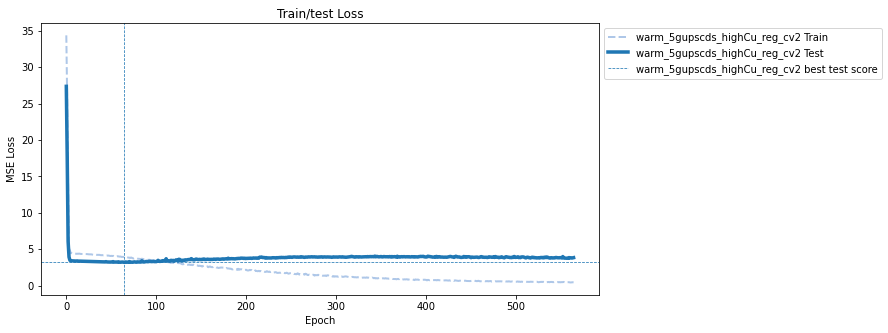

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_5gupscds_highCu_reg_cv2
test split
Predicting for warm_5gupscds_highCu_reg_cv2


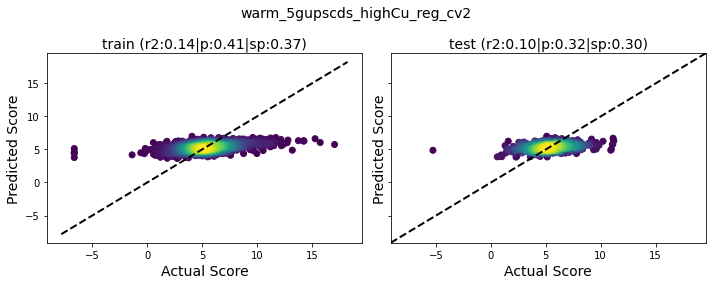

___Running CV3___


E:153 | train loss:2.519 | val loss: 4.675:   3%|▎         | 154/5000 [00:11<06:09, 13.11it/s]

EarlyStopping counter: 125 out of 500


E:278 | train loss:1.286 | val loss: 4.724:   6%|▌         | 278/5000 [00:21<05:59, 13.13it/s]

EarlyStopping counter: 250 out of 500


E:403 | train loss:0.702 | val loss: 4.996:   8%|▊         | 404/5000 [00:30<05:51, 13.07it/s]

EarlyStopping counter: 375 out of 500


E:526 | train loss:0.483 | val loss: 4.804:  11%|█         | 526/5000 [00:40<05:41, 13.09it/s]


EarlyStopping counter: 500 out of 500
Early stopping


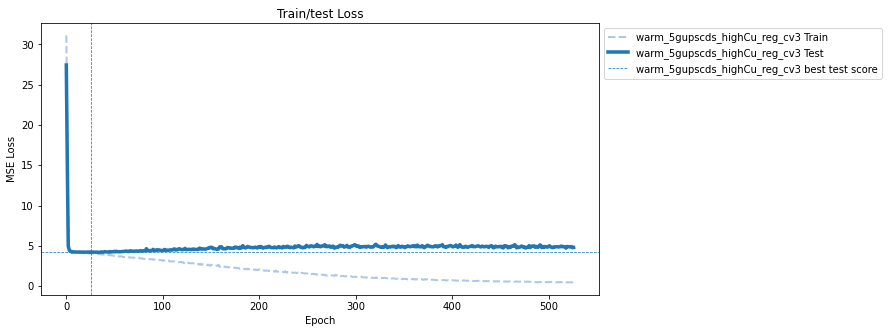

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_5gupscds_highCu_reg_cv3
test split
Predicting for warm_5gupscds_highCu_reg_cv3


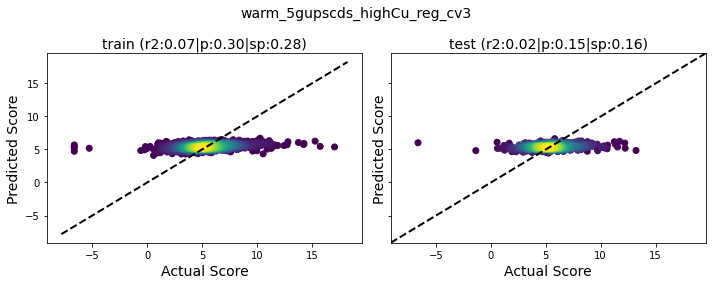

___Running CV4___


E:183 | train loss:2.190 | val loss: 4.993:   4%|▎         | 184/5000 [00:14<06:04, 13.20it/s]

EarlyStopping counter: 125 out of 500


E:308 | train loss:1.089 | val loss: 5.259:   6%|▌         | 308/5000 [00:23<05:58, 13.10it/s]

EarlyStopping counter: 250 out of 500


E:433 | train loss:0.623 | val loss: 5.478:   9%|▊         | 434/5000 [00:33<05:47, 13.14it/s]

EarlyStopping counter: 375 out of 500


E:556 | train loss:0.420 | val loss: 5.695:  11%|█         | 556/5000 [00:42<05:38, 13.12it/s]


EarlyStopping counter: 500 out of 500
Early stopping


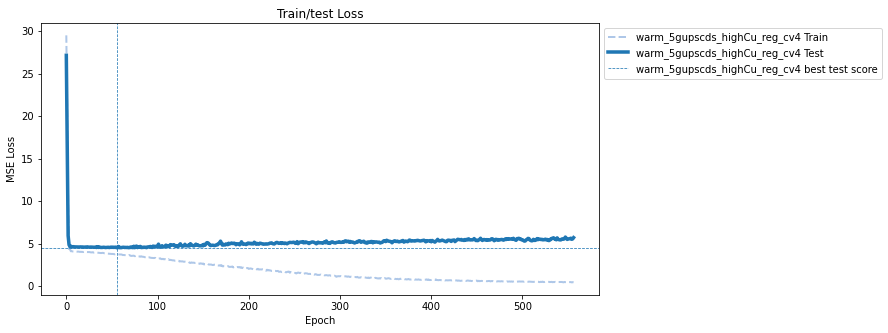

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_5gupscds_highCu_reg_cv4
test split
Predicting for warm_5gupscds_highCu_reg_cv4


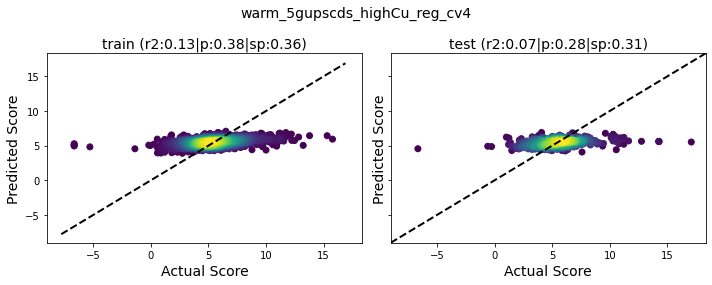

In [63]:
presplit_dir = 'highCu_logTPM_reg_splits'
target_col = 'highCu'
seq_col = 'upstream_region'
locus_col = 'locus_tag'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    split_dfs = {
        'train':train_df,
        'test':test_df
    }

    # create data loaders    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    # NO SAMPLER for regression
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_reg = (seq_len,1) # single task regression
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_reg,**m_kwargs)
    model.load_state_dict(model_5g_ups_cds_cls_weights,strict=False)
    model_name = f"warm_5gupscds_highCu_reg_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='regression'
    )

    model_res_regr[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.parity_pred_by_split(
        model,
        model_name,
        DEVICE,
        split_dfs,
        locus_col=locus_col,
        seq_col=seq_col,
        target_col=target_col,
        splits=['train','test'],
        #save_file=f"{out_dir}/{model_name}_parity_plot.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "regular"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_logTPM_regr'
    p_res_df['start'] = 'model_5g_ups_cds_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs_regr[model_name] = p_res_df

#### Shuffled warm start ups/cds for regression task

___Running CV0___


E:162 | train loss:2.978 | val loss: 4.910:   3%|▎         | 162/5000 [00:12<06:06, 13.20it/s]

EarlyStopping counter: 125 out of 500


E:287 | train loss:1.656 | val loss: 5.390:   6%|▌         | 288/5000 [00:21<05:56, 13.21it/s]

EarlyStopping counter: 250 out of 500


E:412 | train loss:0.808 | val loss: 5.581:   8%|▊         | 412/5000 [00:31<05:46, 13.23it/s]

EarlyStopping counter: 375 out of 500


E:535 | train loss:0.525 | val loss: 5.393:  11%|█         | 535/5000 [00:40<05:38, 13.18it/s]


EarlyStopping counter: 500 out of 500
Early stopping


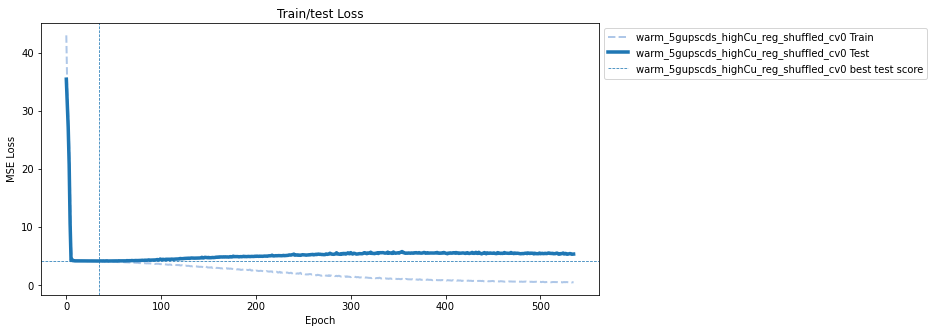

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_5gupscds_highCu_reg_shuffled_cv0
test split
Predicting for warm_5gupscds_highCu_reg_shuffled_cv0


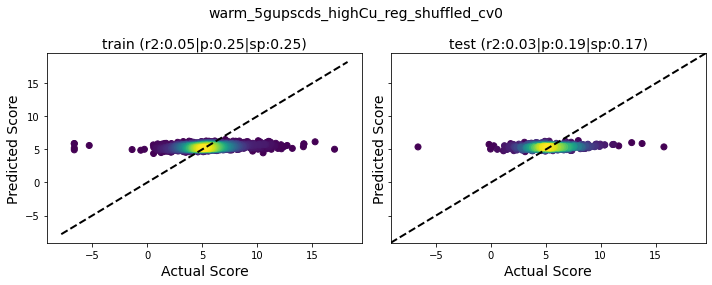

___Running CV1___


E:135 | train loss:3.168 | val loss: 5.025:   3%|▎         | 136/5000 [00:10<06:07, 13.22it/s]

EarlyStopping counter: 125 out of 500


E:260 | train loss:1.384 | val loss: 5.542:   5%|▌         | 260/5000 [00:19<05:57, 13.27it/s]

EarlyStopping counter: 250 out of 500


E:385 | train loss:0.709 | val loss: 5.600:   8%|▊         | 386/5000 [00:29<05:47, 13.26it/s]

EarlyStopping counter: 375 out of 500


E:508 | train loss:0.442 | val loss: 5.619:  10%|█         | 508/5000 [00:38<05:39, 13.23it/s]


EarlyStopping counter: 500 out of 500
Early stopping


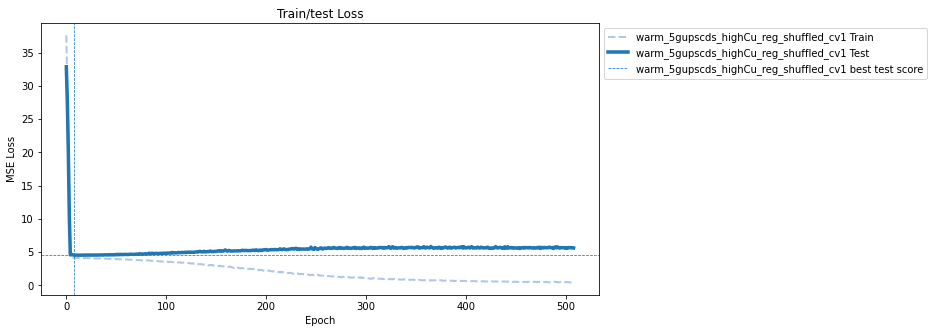

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_5gupscds_highCu_reg_shuffled_cv1
test split
Predicting for warm_5gupscds_highCu_reg_shuffled_cv1


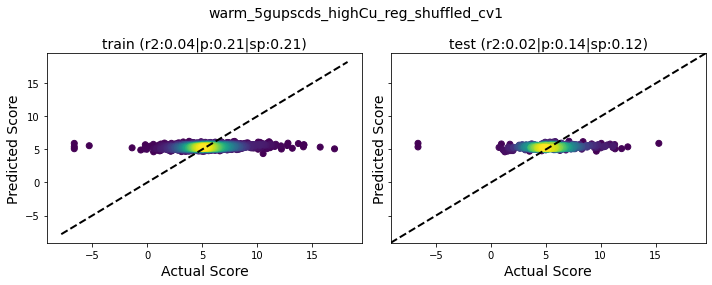

___Running CV2___


E:160 | train loss:2.689 | val loss: 4.202:   3%|▎         | 160/5000 [00:12<06:03, 13.30it/s]

EarlyStopping counter: 125 out of 500


E:285 | train loss:1.291 | val loss: 4.608:   6%|▌         | 286/5000 [00:21<05:54, 13.30it/s]

EarlyStopping counter: 250 out of 500


E:410 | train loss:0.772 | val loss: 4.467:   8%|▊         | 410/5000 [00:30<05:45, 13.28it/s]

EarlyStopping counter: 375 out of 500


E:533 | train loss:0.552 | val loss: 4.398:  11%|█         | 533/5000 [00:40<05:36, 13.27it/s]


EarlyStopping counter: 500 out of 500
Early stopping


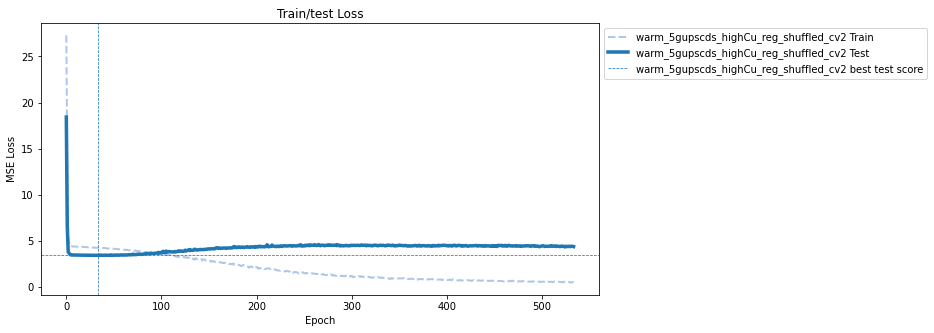

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_5gupscds_highCu_reg_shuffled_cv2
test split
Predicting for warm_5gupscds_highCu_reg_shuffled_cv2


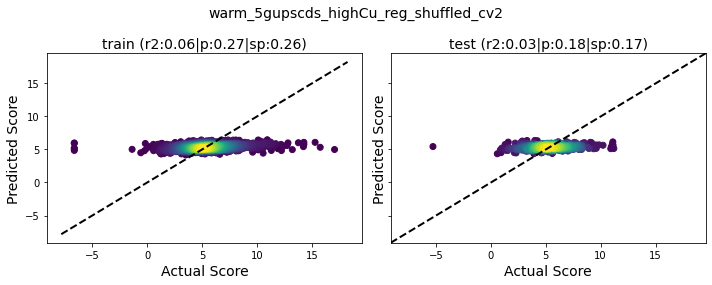

___Running CV3___


E:184 | train loss:2.860 | val loss: 5.137:   4%|▎         | 184/5000 [00:14<06:10, 13.01it/s]

EarlyStopping counter: 125 out of 500


E:309 | train loss:1.703 | val loss: 5.570:   6%|▌         | 310/5000 [00:23<06:00, 13.02it/s]

EarlyStopping counter: 250 out of 500


E:434 | train loss:1.014 | val loss: 5.772:   9%|▊         | 434/5000 [00:33<05:52, 12.97it/s]

EarlyStopping counter: 375 out of 500


E:557 | train loss:0.687 | val loss: 5.632:  11%|█         | 557/5000 [00:42<05:42, 12.97it/s]


EarlyStopping counter: 500 out of 500
Early stopping


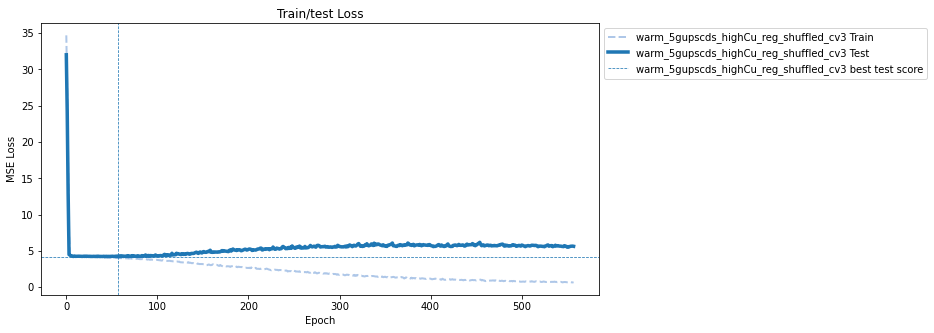

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_5gupscds_highCu_reg_shuffled_cv3
test split
Predicting for warm_5gupscds_highCu_reg_shuffled_cv3


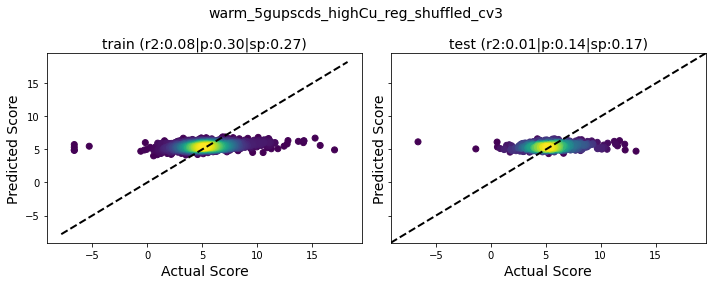

___Running CV4___


E:156 | train loss:2.481 | val loss: 5.436:   3%|▎         | 156/5000 [00:12<06:13, 12.95it/s]

EarlyStopping counter: 125 out of 500


E:281 | train loss:1.297 | val loss: 5.698:   6%|▌         | 282/5000 [00:21<06:02, 13.02it/s]

EarlyStopping counter: 250 out of 500


E:406 | train loss:0.818 | val loss: 5.962:   8%|▊         | 406/5000 [00:31<05:55, 12.91it/s]

EarlyStopping counter: 375 out of 500


E:529 | train loss:0.598 | val loss: 5.843:  11%|█         | 529/5000 [00:40<05:45, 12.93it/s]


EarlyStopping counter: 500 out of 500
Early stopping


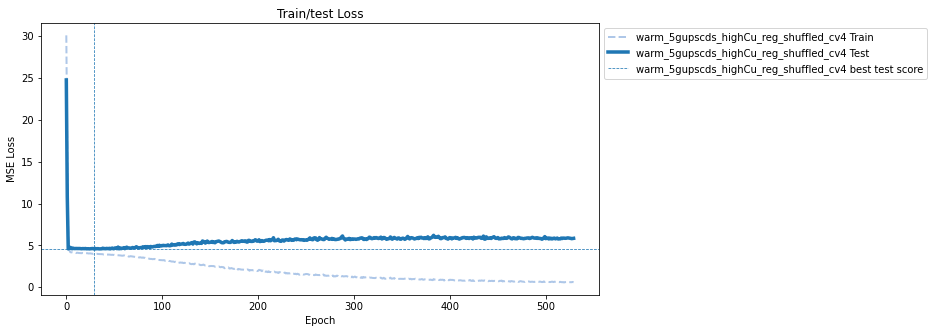

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for warm_5gupscds_highCu_reg_shuffled_cv4
test split
Predicting for warm_5gupscds_highCu_reg_shuffled_cv4


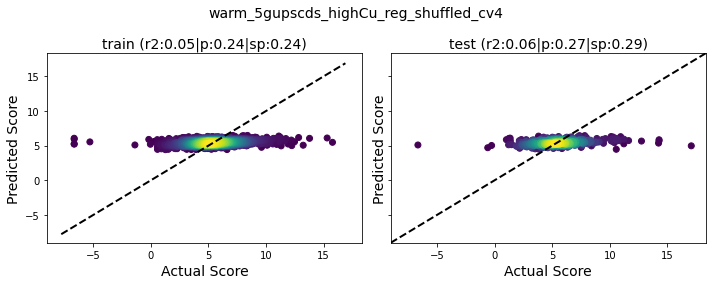

In [64]:
presplit_dir = 'highCu_logTPM_reg_splits'
target_col = 'highCu'
seq_col = 'shuffled_seq'
locus_col = 'locus_tag'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/{presplit_dir}/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    split_dfs = {
        'train':train_df,
        'test':test_df
    }

    # create data loaders    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    # NO SAMPLER for regression
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args_cu_reg = (seq_len,1) # single task regression
    
    # WARM START!
    model = m.DNA_2CNN_2FC(*m_args_cu_reg,**m_kwargs)
    model.load_state_dict(model_5g_ups_cds_cls_weights,strict=False)
    model_name = f"warm_5gupscds_highCu_reg_shuffled_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='regression'
    )

    model_res_regr[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.parity_pred_by_split(
        model,
        model_name,
        DEVICE,
        split_dfs,
        locus_col=locus_col,
        seq_col=seq_col,
        target_col=target_col,
        splits=['train','test'],
        #save_file=f"{out_dir}/{model_name}_parity_plot.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "shuffled"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_logTPM_regr'
    p_res_df['start'] = 'model_5g_ups_cds_cls_weights'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs_regr[model_name] = p_res_df

In [65]:
all_preds_regr = pd.concat([pred_dfs_regr[x] for x in pred_dfs_regr])
all_preds_regr

model_name  split        r2   pearson  spearman  \
0                    warm_highCu_reg_cv0  train  0.153770  0.418345  0.378446   
1                    warm_highCu_reg_cv0   test  0.047681  0.221951  0.217179   
0                    warm_highCu_reg_cv1  train  0.281386  0.564318  0.501685   
1                    warm_highCu_reg_cv1   test  0.055495  0.251498  0.172818   
0                    warm_highCu_reg_cv2  train  0.203785  0.500631  0.423010   
1                    warm_highCu_reg_cv2   test  0.079245  0.283334  0.294195   
0                    warm_highCu_reg_cv3  train  0.046232  0.216172  0.211507   
1                    warm_highCu_reg_cv3   test -0.004486  0.118765  0.146603   
0                    warm_highCu_reg_cv4  train  0.156360  0.434431  0.392785   
1                    warm_highCu_reg_cv4   test  0.064125  0.278778  0.270853   
0           warm_highCu_reg_shuffled_cv0  train  0.057060  0.274447  0.262411   
1           warm_highCu_reg_shuffled_cv0   test  0.006633  0.123014  0.139036   
0           warm_highCu_reg_shuffled_cv1  train  0.038591  0.211462  0.182348   
1           warm_highCu_reg_shuffled_cv1   test -0.001840  0.101880  0.100927   
0           warm_highCu_reg_shuffled_cv2  train  0.048651  0.245589  0.231740   
1           warm_highCu_reg_shuffled_cv2   test  0.013919  0.143260  0.145821   
0           warm_highCu_reg_shuffled_cv3  train  0.002895  0.122774  0.107279   
1           warm_highCu_reg_shuffled_cv3   test  0.012126  0.131004  0.142640   
0           warm_highCu_reg_shuffled_cv4  train  0.092309  0.337067  0.312658   
1           warm_highCu_reg_shuffled_cv4   test  0.021621  0.179556  0.181051   
0           warm_5gupscds_highCu_reg_cv0  train  0.173493  0.434405  0.395928   
1           warm_5gupscds_highCu_reg_cv0   test  0.057332  0.247536  0.242003   
0           warm_5gupscds_highCu_reg_cv1  train  0.214747  0.483903  0.441144   
1           warm_5gupscds_highCu_reg_cv1   test  0.050340  0.237971  0.194272   
0           warm_5gupscds_highCu_reg_cv2  train  0.139469  0.410203  0.374800   
1           warm_5gupscds_highCu_reg_cv2   test  0.100579  0.317879  0.298435   
0           warm_5gupscds_highCu_reg_cv3  train  0.074984  0.296225  0.284809   
1           warm_5gupscds_highCu_reg_cv3   test  0.016435  0.148680  0.164918   
0           warm_5gupscds_highCu_reg_cv4  train  0.126527  0.380275  0.358626   
1           warm_5gupscds_highCu_reg_cv4   test  0.074295  0.283927  0.305362   
0  warm_5gupscds_highCu_reg_shuffled_cv0  train  0.050949  0.250200  0.251056   
1  warm_5gupscds_highCu_reg_shuffled_cv0   test  0.033180  0.188912  0.172775   
0  warm_5gupscds_highCu_reg_shuffled_cv1  train  0.036372  0.209720  0.214839   
1  warm_5gupscds_highCu_reg_shuffled_cv1   test  0.017652  0.138835  0.124943   
0  warm_5gupscds_highCu_reg_shuffled_cv2  train  0.057666  0.265669  0.264847   
1  warm_5gupscds_highCu_reg_shuffled_cv2   test  0.031116  0.177616  0.173944   
0  warm_5gupscds_highCu_reg_shuffled_cv3  train  0.082540  0.302240  0.273289   
1  warm_5gupscds_highCu_reg_shuffled_cv3   test  0.013536  0.140800  0.170458   
0  warm_5gupscds_highCu_reg_shuffled_cv4  train  0.054016  0.244431  0.242036   
1  warm_5gupscds_highCu_reg_shuffled_cv4   test  0.061331  0.274118  0.289100   

  model_type  seq_mode  fold                task  \
0        CNN   regular     0  highCu_logTPM_regr   
1        CNN   regular     0  highCu_logTPM_regr   
0        CNN   regular     1  highCu_logTPM_regr   
1        CNN   regular     1  highCu_logTPM_regr   
0        CNN   regular     2  highCu_logTPM_regr   
1        CNN   regular     2  highCu_logTPM_regr   
0        CNN   regular     3  highCu_logTPM_regr   
1        CNN   regular     3  highCu_logTPM_regr   
0        CNN   regular     4  highCu_logTPM_regr   
1        CNN   regular     4  highCu_logTPM_regr   
0        CNN  shuffled     0  highCu_logTPM_regr   
1        CNN  shuffled     0  highCu_logTPM_regr   
0        CNN  shuffled     1  hi

In [66]:
# get predictions from just the 2nd warm start option (ups_cds_cls)
warm2_preds_regr = pd.concat([pred_dfs_regr[x] for x in pred_dfs_regr if 'ups' in x])
warm2_preds_regr

model_name  split        r2   pearson  spearman  \
0           warm_5gupscds_highCu_reg_cv0  train  0.173493  0.434405  0.395928   
1           warm_5gupscds_highCu_reg_cv0   test  0.057332  0.247536  0.242003   
0           warm_5gupscds_highCu_reg_cv1  train  0.214747  0.483903  0.441144   
1           warm_5gupscds_highCu_reg_cv1   test  0.050340  0.237971  0.194272   
0           warm_5gupscds_highCu_reg_cv2  train  0.139469  0.410203  0.374800   
1           warm_5gupscds_highCu_reg_cv2   test  0.100579  0.317879  0.298435   
0           warm_5gupscds_highCu_reg_cv3  train  0.074984  0.296225  0.284809   
1           warm_5gupscds_highCu_reg_cv3   test  0.016435  0.148680  0.164918   
0           warm_5gupscds_highCu_reg_cv4  train  0.126527  0.380275  0.358626   
1           warm_5gupscds_highCu_reg_cv4   test  0.074295  0.283927  0.305362   
0  warm_5gupscds_highCu_reg_shuffled_cv0  train  0.050949  0.250200  0.251056   
1  warm_5gupscds_highCu_reg_shuffled_cv0   test  0.033180  0.188912  0.172775   
0  warm_5gupscds_highCu_reg_shuffled_cv1  train  0.036372  0.209720  0.214839   
1  warm_5gupscds_highCu_reg_shuffled_cv1   test  0.017652  0.138835  0.124943   
0  warm_5gupscds_highCu_reg_shuffled_cv2  train  0.057666  0.265669  0.264847   
1  warm_5gupscds_highCu_reg_shuffled_cv2   test  0.031116  0.177616  0.173944   
0  warm_5gupscds_highCu_reg_shuffled_cv3  train  0.082540  0.302240  0.273289   
1  warm_5gupscds_highCu_reg_shuffled_cv3   test  0.013536  0.140800  0.170458   
0  warm_5gupscds_highCu_reg_shuffled_cv4  train  0.054016  0.244431  0.242036   
1  warm_5gupscds_highCu_reg_shuffled_cv4   test  0.061331  0.274118  0.289100   

  model_type  seq_mode  fold                task  \
0        CNN   regular     0  highCu_logTPM_regr   
1        CNN   regular     0  highCu_logTPM_regr   
0        CNN   regular     1  highCu_logTPM_regr   
1        CNN   regular     1  highCu_logTPM_regr   
0        CNN   regular     2  highCu_logTPM_regr   
1        CNN   regular     2  highCu_logTPM_regr   
0        CNN   regular     3  highCu_logTPM_regr   
1        CNN   regular     3  highCu_logTPM_regr   
0        CNN   regular     4  highCu_logTPM_regr   
1        CNN   regular     4  highCu_logTPM_regr   
0        CNN  shuffled     0  highCu_logTPM_regr   
1        CNN  shuffled     0  highCu_logTPM_regr   
0        CNN  shuffled     1  highCu_logTPM_regr   
1        CNN  shuffled     1  highCu_logTPM_regr   
0        CNN  shuffled     2  highCu_logTPM_regr   
1        CNN  shuffled     2  highCu_logTPM_regr   
0        CNN  shuffled     3  highCu_logTPM_regr   
1        CNN  shuffled     3  highCu_logTPM_regr   
0        CNN  shuffled     4  highCu_logTPM_regr   
1        CNN  shuffled     4  highCu_logTPM_regr   

                          start  best_val_score  epoch_stop  total_time  
0  model_5g_ups_cds_cls_weights        4.098082          41   40.778910  
1  model_5g_ups_cds_cls_weights        4.098082          41   40.778910  
0  model_5g_ups_cds_cls_weights        4.377922          84   44.839842  
1  model_5g_ups_cds_cls_weights        4.377922          84   44.839842  
0  model_5g_ups_cds_cls_weights        3.200906          64   43.342710  
1  model_5g_ups_cds_cls_weights        3.200906          64   43.342710  
0  model_5g_ups_cds_cls_weights        4.198663          26   40.193110  
1  model_5g_ups_cds_cls_weights        4.198663          26   40.193110  
0  model_5g_ups_cds_cls_weights        4.508740          56   42.380896  
1  model_5g_ups_cds_cls_weights        4.508740          56   42.380896  
0  model_5g_ups_cds_cls_weights        4.203081          35   40.596000  
1  model_5g_ups_cds_cls_weights        4.203081          35   40.596000  
0  model_5g_ups_cds_cls_weights        4.528615           8   38.414717  
1  model_5g_ups_cds_cls_weights        4.528615           8   38.414717  
0  model_5g_ups_cds_cls_weights        3.448117          33   40.170672  
1  model_5g_ups_cds_cls_weights        3.448117    

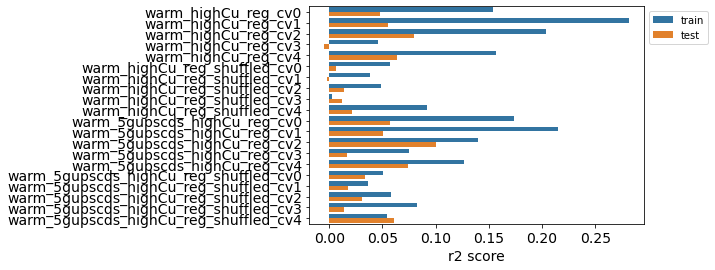

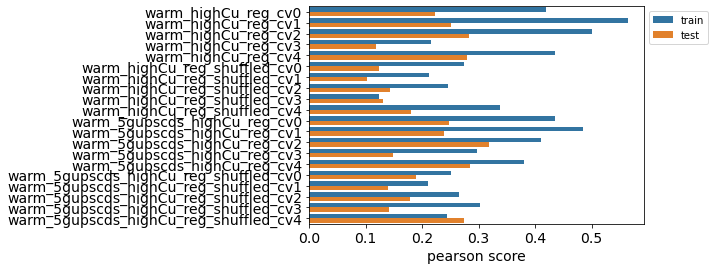

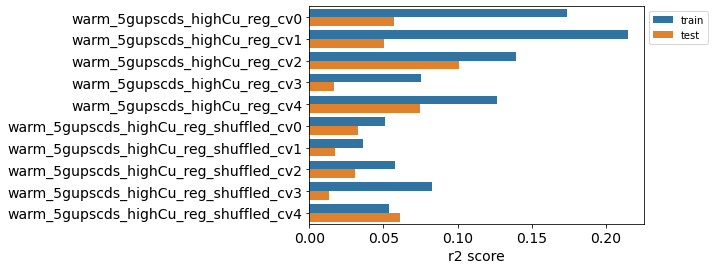

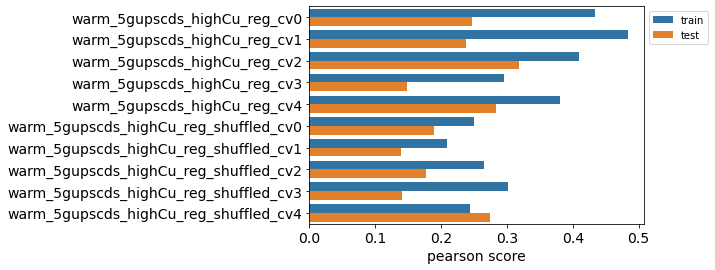

In [67]:
plot_metric(all_preds_regr,'r2')
plot_metric(all_preds_regr,'pearson')

plot_metric(warm2_preds_regr,'r2')
plot_metric(warm2_preds_regr,'pearson')

In [68]:
def check_pred_score_dist_reg(pred_df):
    df_train = pred_df[pred_df['split']=='train']
    df_test = pred_df[pred_df['split']=='test']
    
    # TRAIN plot
    g = sns.catplot(
        data=df_train, x='seq_mode', y='r2',
        kind='box',
        boxprops=dict(alpha=.3),height=3,aspect=4/2
    )
    g.map_dataframe(sns.swarmplot, 
                    x='seq_mode', y='r2',
                    size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

    for ax in g.axes.flatten():
        #ax.set_xlabel('Dataset size', fontsize=14)
        ax.set_ylabel('R2 score', fontsize=14)
    plt.xlabel("Seq Mode",fontsize=14)
    plt.title("Train set classification performance",fontsize=20)
    plt.show()
    
    g = sns.catplot(
        data=df_train, x='seq_mode', y='pearson',
        kind='box',
        boxprops=dict(alpha=.3),height=3,aspect=4/2
    )
    g.map_dataframe(sns.swarmplot, 
                    x='seq_mode', y='pearson',
                    size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

    for ax in g.axes.flatten():
        #ax.set_xlabel('Dataset size', fontsize=14)
        ax.set_ylabel('Pearson score', fontsize=14)
    plt.xlabel("Seq Mode",fontsize=14)
    plt.title("Train set classification performance",fontsize=20)
    plt.show()
    
    # TEST plot
    g = sns.catplot(
        data=df_test, x='seq_mode', y='r2',
        kind='box',
        boxprops=dict(alpha=.3),height=3,aspect=4/2
    )
    g.map_dataframe(sns.swarmplot, 
                    x='seq_mode', y='r2',
                    size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

    for ax in g.axes.flatten():
        #ax.set_xlabel('Dataset size', fontsize=14)
        ax.set_ylabel('R2 score', fontsize=14)
    plt.xlabel("Seq Mode",fontsize=14)
    plt.title("Test set classification performance",fontsize=20)
    plt.show()
    
    # TEST plot
    g = sns.catplot(
        data=df_test, x='seq_mode', y='pearson',
        kind='box',
        boxprops=dict(alpha=.3),height=3,aspect=4/2
    )
    g.map_dataframe(sns.swarmplot, 
                    x='seq_mode', y='pearson',
                    size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

    for ax in g.axes.flatten():
        #ax.set_xlabel('Dataset size', fontsize=14)
        ax.set_ylabel('Pearson score', fontsize=14)
    plt.xlabel("Seq Mode",fontsize=14)
    plt.title("Test set classification performance",fontsize=20)
    plt.show()
    
    
    # t test
    regular_scores = df_test[df_test['seq_mode']=='regular']['r2'].values
    shuffled_scores = df_test[df_test['seq_mode']=='shuffled']['r2'].values
    print("T-test:",ttest_ind(regular_scores, shuffled_scores))
    print()
    print("Mean R2 for regular seqs:",np.mean(regular_scores))
    print("Mean R2 for shuffled seqs:",np.mean(shuffled_scores))
    print()
    
    regular_scores = df_test[df_test['seq_mode']=='regular']['pearson'].values
    shuffled_scores = df_test[df_test['seq_mode']=='shuffled']['pearson'].values
    print("T-test:",ttest_ind(regular_scores, shuffled_scores))
    print()
    print("Mean pearson for regular seqs:",np.mean(regular_scores))
    print("Mean pearson for shuffled seqs:",np.mean(shuffled_scores))
    

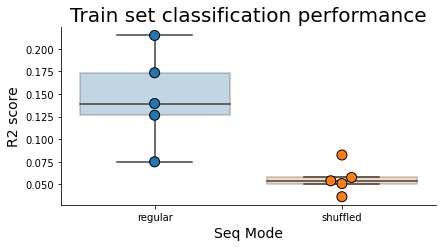

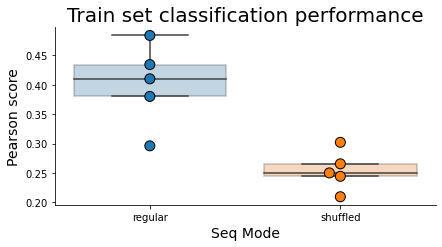

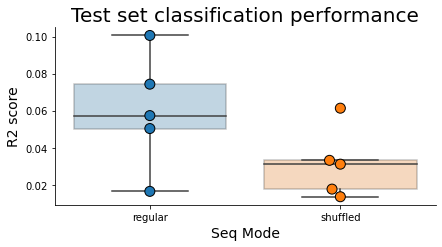

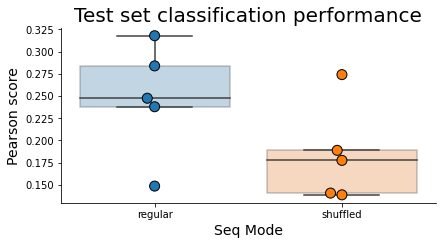

T-test: Ttest_indResult(statistic=1.7539029836822588, pvalue=0.11753268744279687)

Mean R2 for regular seqs: 0.05979637655681658
Mean R2 for shuffled seqs: 0.031362752024872154

T-test: Ttest_indResult(statistic=1.6807052898882906, pvalue=0.13132867860526762)

Mean pearson for regular seqs: 0.24719844564687574
Mean pearson for shuffled seqs: 0.18405643184585468


In [69]:
check_pred_score_dist_reg(warm2_preds_regr)